<a href="https://colab.research.google.com/github/nicolelnunes/MasterThesis/blob/main/PlanAPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [ ]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 13.5 MB/s eta 0:00:00


In [ ]:
pip install bertopic[spacy]

In [ ]:
pip install huggingface_hub

In [ ]:
#!pip install transformers
#!pip install --upgrade sentence-transformers

In [ ]:
pip install numpy==1.19.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
pip install torchmetrics

In [ ]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

# Install spaCy model
!python -m spacy download pt_core_news_lg

# Core libraries
import re
import string
import csv
from functools import reduce
from itertools import chain

# NLP Libraries
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import spacy

# Data handling
import openpyxl
import pandas as pd

# Visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# Load Portuguese NLP model
nlp = spacy.load("pt_core_news_lg")
stopwords = nltk.corpus.stopwords.words('portuguese')

from torch import rand, randint
from torchmetrics.text import Perplexity

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


ModuleNotFoundError: No module named 'torchmetrics'

In [ ]:
from huggingface_hub import hf_hub_download
from bertopic import BERTopic

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


# Data Understanding


##Import and Structure Data

In [ ]:
excel = pd.ExcelFile("drive/MyDrive/Data/anonymized_workshops_pontes.xlsx")

science = pd.read_excel(excel, 'D. Ciência')
policies = pd.read_excel(excel, 'D. Pol. Pub.')
both = pd.read_excel(excel, 'D. Ambos')
solutions = pd.read_excel(excel, 'Soluções')
strategies = pd.read_excel(excel, 'Estratégias')
actions = pd.read_excel(excel, 'Ações')
info = pd.read_excel(excel, 'Sheet8')


In [ ]:
print(both.info)

<bound method DataFrame.info of      Workshop Centro Investigação   Ano Distrito             Área Científica  \
0           1                ID_1  2023   Lisboa           Ciências agrárias   
1           1                ID_1  2023   Lisboa           Ciências agrárias   
2           1                ID_1  2023   Lisboa           Ciências agrárias   
3           1                ID_1  2023   Lisboa           Ciências agrárias   
4           1                ID_1  2023   Lisboa           Ciências agrárias   
..        ...                 ...   ...      ...                         ...   
254        27               ID_25  2024   Lisboa  Ciências exatas e naturais   
255        27               ID_25  2024   Lisboa  Ciências exatas e naturais   
256        27               ID_25  2024   Lisboa  Ciências exatas e naturais   
257        27               ID_25  2024   Lisboa  Ciências exatas e naturais   
258        27               ID_25  2024   Lisboa  Ciências exatas e naturais   

       

In [ ]:
import json
import os

In [ ]:
data = [science, policies, both, solutions, strategies, actions]

In [ ]:
for df in data:
  print("############################################")
  print(len(df))

############################################
224
############################################
285
############################################
259
############################################
425
############################################
383
############################################
245


In [ ]:
def rm_null(df):
  last_column_name = df.columns[-1]
  return df.dropna(subset=[last_column_name], inplace=True)

for df in data:
  rm_null(df)


In [ ]:
for df in data:
  print("############################################")
  print(len(df))
  print(df)

############################################
224
     Workshop ID Centro Investigação   Ano   Distrito  \
0              1                ID_1  2023     Lisboa   
1              1                ID_1  2023     Lisboa   
2              1                ID_1  2023     Lisboa   
3              1                ID_1  2023     Lisboa   
4              1                ID_1  2023     Lisboa   
..           ...                 ...   ...        ...   
219           28               ID_26  2024  Vila Real   
220           29               ID_27  2024    Setúbal   
221           29               ID_27  2024    Setúbal   
222           29               ID_27  2024    Setúbal   
223           29               ID_27  2024    Setúbal   

                Área Científica  \
0             Ciências agrárias   
1             Ciências agrárias   
2             Ciências agrárias   
3             Ciências agrárias   
4             Ciências agrárias   
..                          ...   
219  Ciências exatas 

In [ ]:
def mean(df):
  total_words = 0
  total_sentences =0
  for text in df[df.columns[-1]]:
    total_words += len(text.split())
    total_sentences += 1
  return total_words/total_sentences


In [ ]:
total=0
lengths = 0
for df in data:
  print("############################################")
  mean_words = mean(df)
  total += mean_words
  print(mean_words)
  print(len(df))
  lengths += len(df)
print(total/len(data))
print(lengths)

############################################
5.544642857142857
224
############################################
5.242105263157895
285
############################################
4.888030888030888
259
############################################
6.285377358490566
424
############################################
5.754617414248021
379
############################################
7.481171548117155
239
5.865990888197897
1810


In [ ]:
print(mean(science))

1.5


## N-gram per sheet w/o preprocessing

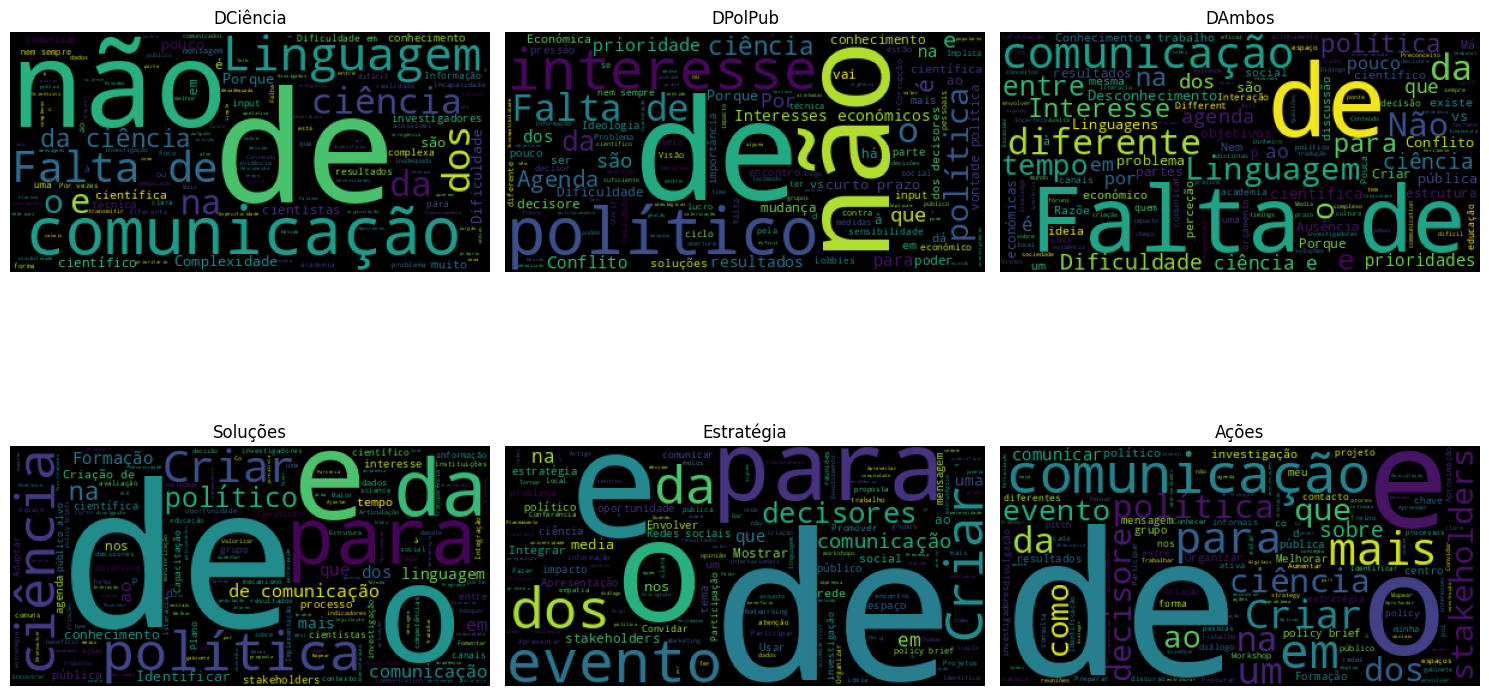

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots

axes = axes.flatten()

for i, df in enumerate(data):
  wc = WordCloud().generate(df[df.columns[-1]].to_string())
  axes[i].imshow(wc)
  axes[i].set_title(df.columns[-1])
  axes[i].axis("off")

plt.tight_layout()
plt.show()

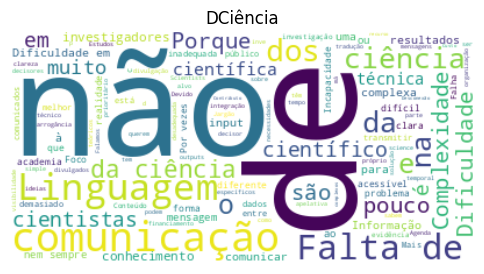

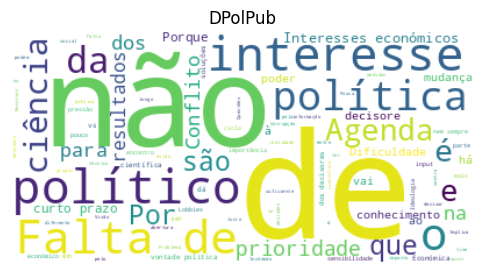

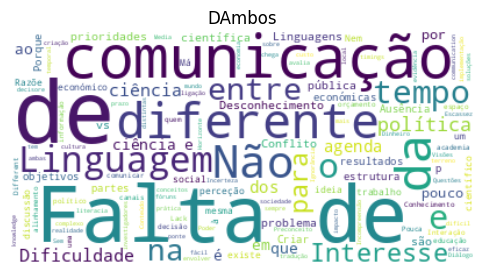

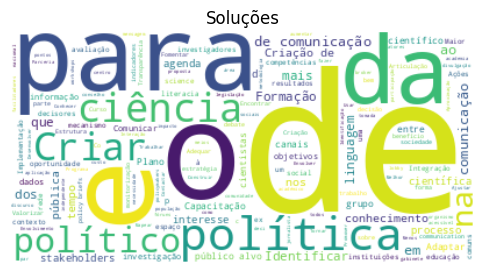

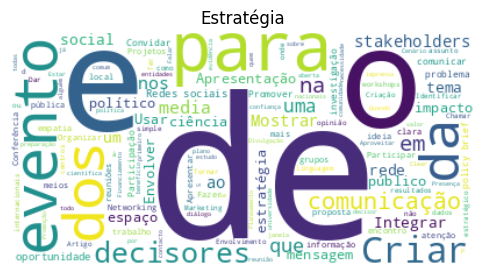

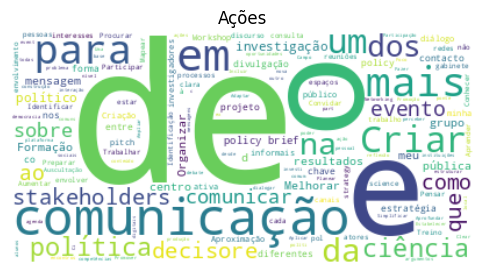

In [ ]:
for i, df in enumerate(data):
    wc = WordCloud(background_color="white").generate(df[df.columns[-1]].to_string())

    plt.figure(figsize=(6, 6))  # new figure each time
    plt.imshow(wc, interpolation="bilinear")
    plt.title(df.columns[-1])
    plt.axis("off")
    plt.show()

In [ ]:
def ngram(df_list, n=2):
  ngram_lists = []
  for df in df_list:
    last_column = df.columns[-1]
    for text in df[last_column]:
      tokenized_text = word_tokenize(text)
      n_grams = list(ngrams(tokenized_text, n))
      ngram_lists.append(n_grams)

  return ngram_lists

def ngram(text_list, n=2):
  ngram_lists = []
  for text in text_list:
    tokenized_text = word_tokenize(text)
    n_grams = list(ngrams(tokenized_text, n))
    ngram_lists.append(n_grams)
  return ngram_lists





In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    print(vec.vocabulary_.items())


In [ ]:
text = []
for df in data:
  text.append(df[df.columns[-1]].to_numpy())



In [ ]:
text_list = list(chain(*text))

In [ ]:
print(text_list)

['Informação muito complexa/ específica', 'Linguagem usada', 'Informação complexa', 'Complexidade dos resultados obtidos', 'Pode ser muito “técnica” e não considerar aspetos sociais', 'Porque o input não é oportuno', 'Os investigadores não querem passar a mensagem', 'Foco nos pormenores (falta de abrangência)', 'Falta integração ciência-sociedade', 'Linguagem inadequada', 'Imagem pouco apelativa', 'Serem inconclusivos', 'Porque a ciência, em geral, aceita a distinção (errada) entre valores e factos', 'Falta de intervenção/ participação dos cientistas', 'Porque a ciência não aparece representada no seu conjunto - só por uma visão entre várias', 'Devido à linguagem pouco acessível da ciência ou de alguma ciência', 'Por falta de clareza/eficiência do próprio discurso científico', 'Dificuldade na “transformação” dos outputs em conteúdo entendível pelos decisores', 'Acesso difícil ao leigo', 'Foco disciplinar (não holístico e abrangente)', 'Conteúdos muito específicos', 'Isolamento da acade

In [ ]:
ngram_list = ngram(text_list)
print(ngram_list)
#print(ngram(data, 2))

[[('Informação', 'muito'), ('muito', 'complexa/'), ('complexa/', 'específica')], [('Linguagem', 'usada')], [('Informação', 'complexa')], [('Complexidade', 'dos'), ('dos', 'resultados'), ('resultados', 'obtidos')], [('Pode', 'ser'), ('ser', 'muito'), ('muito', '“'), ('“', 'técnica'), ('técnica', '”'), ('”', 'e'), ('e', 'não'), ('não', 'considerar'), ('considerar', 'aspetos'), ('aspetos', 'sociais')], [('Porque', 'o'), ('o', 'input'), ('input', 'não'), ('não', 'é'), ('é', 'oportuno')], [('Os', 'investigadores'), ('investigadores', 'não'), ('não', 'querem'), ('querem', 'passar'), ('passar', 'a'), ('a', 'mensagem')], [('Foco', 'nos'), ('nos', 'pormenores'), ('pormenores', '('), ('(', 'falta'), ('falta', 'de'), ('de', 'abrangência'), ('abrangência', ')')], [('Falta', 'integração'), ('integração', 'ciência-sociedade')], [('Linguagem', 'inadequada')], [('Imagem', 'pouco'), ('pouco', 'apelativa')], [('Serem', 'inconclusivos')], [('Porque', 'a'), ('a', 'ciência'), ('ciência', ','), (',', 'em'),

In [ ]:
ngram_list = [f"{a} {b}" for sublist in ngram_list for a, b in sublist]
print(ngram_list)


['Informação muito', 'muito complexa/', 'complexa/ específica', 'Linguagem usada', 'Informação complexa', 'Complexidade dos', 'dos resultados', 'resultados obtidos', 'Pode ser', 'ser muito', 'muito “', '“ técnica', 'técnica ”', '” e', 'e não', 'não considerar', 'considerar aspetos', 'aspetos sociais', 'Porque o', 'o input', 'input não', 'não é', 'é oportuno', 'Os investigadores', 'investigadores não', 'não querem', 'querem passar', 'passar a', 'a mensagem', 'Foco nos', 'nos pormenores', 'pormenores (', '( falta', 'falta de', 'de abrangência', 'abrangência )', 'Falta integração', 'integração ciência-sociedade', 'Linguagem inadequada', 'Imagem pouco', 'pouco apelativa', 'Serem inconclusivos', 'Porque a', 'a ciência', 'ciência ,', ', em', 'em geral', 'geral ,', ', aceita', 'aceita a', 'a distinção', 'distinção (', '( errada', 'errada )', ') entre', 'entre valores', 'valores e', 'e factos', 'Falta de', 'de intervenção/', 'intervenção/ participação', 'participação dos', 'dos cientistas', 'P

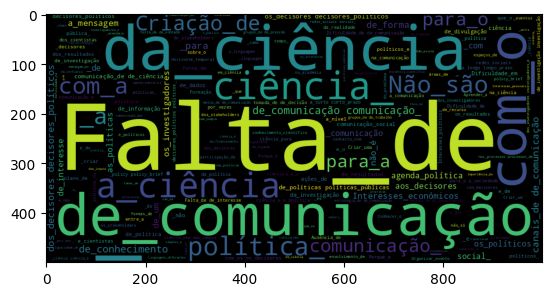

In [ ]:
bigram_wc = ' '.join(bigram.replace(' ', '_') for bigram in ngram_list)
wc = WordCloud(width = 1000, height = 500).generate(bigram_wc)
plt.imshow(wc)

[[('Informação', 'muito', 'complexa/'), ('muito', 'complexa/', 'específica')], [], [], [('Complexidade', 'dos', 'resultados'), ('dos', 'resultados', 'obtidos')], [('Pode', 'ser', 'muito'), ('ser', 'muito', '“'), ('muito', '“', 'técnica'), ('“', 'técnica', '”'), ('técnica', '”', 'e'), ('”', 'e', 'não'), ('e', 'não', 'considerar'), ('não', 'considerar', 'aspetos'), ('considerar', 'aspetos', 'sociais')], [('Porque', 'o', 'input'), ('o', 'input', 'não'), ('input', 'não', 'é'), ('não', 'é', 'oportuno')], [('Os', 'investigadores', 'não'), ('investigadores', 'não', 'querem'), ('não', 'querem', 'passar'), ('querem', 'passar', 'a'), ('passar', 'a', 'mensagem')], [('Foco', 'nos', 'pormenores'), ('nos', 'pormenores', '('), ('pormenores', '(', 'falta'), ('(', 'falta', 'de'), ('falta', 'de', 'abrangência'), ('de', 'abrangência', ')')], [('Falta', 'integração', 'ciência-sociedade')], [], [('Imagem', 'pouco', 'apelativa')], [], [('Porque', 'a', 'ciência'), ('a', 'ciência', ','), ('ciência', ',', 'em'

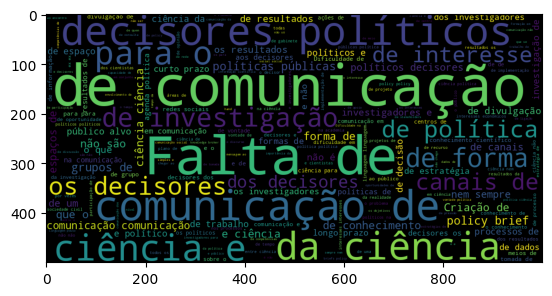

In [ ]:
trigram = ngram(text_list, 3)
print(trigram)
trigram_list = [f"{a} {b} {c}" for sublist in trigram for a, b, c in sublist]
print(trigram_list)
trigram_str = ' '.join(trigram_list)
trigram_wc = ' '.join(trigram.replace(' ', '_') for trigram in trigram_list)
wc = WordCloud(width = 1000, height = 500, collocation_threshold = 1).generate(trigram_str)
plt.imshow(wc)

In [ ]:
print(trigram_wc)

Informação_muito_complexa/ muito_complexa/_específica Complexidade_dos_resultados dos_resultados_obtidos Pode_ser_muito ser_muito_“ muito_“_técnica “_técnica_” técnica_”_e ”_e_não e_não_considerar não_considerar_aspetos considerar_aspetos_sociais Porque_o_input o_input_não input_não_é não_é_oportuno Os_investigadores_não investigadores_não_querem não_querem_passar querem_passar_a passar_a_mensagem Foco_nos_pormenores nos_pormenores_( pormenores_(_falta (_falta_de falta_de_abrangência de_abrangência_) Falta_integração_ciência-sociedade Imagem_pouco_apelativa Porque_a_ciência a_ciência_, ciência_,_em ,_em_geral em_geral_, geral_,_aceita ,_aceita_a aceita_a_distinção a_distinção_( distinção_(_errada (_errada_) errada_)_entre )_entre_valores entre_valores_e valores_e_factos Falta_de_intervenção/ de_intervenção/_participação intervenção/_participação_dos participação_dos_cientistas Porque_a_ciência a_ciência_não ciência_não_aparece não_aparece_representada aparece_representada_no representa

In [ ]:
def mean_str(text_list):
  total_words = 0
  total_sentences = 0
  for text in text_list:
    total_words += len(text.split())
    total_sentences += 1
  return total_words/total_sentences

print(mean_str(text_list))

5.8762430939226515


In [ ]:
print(len(text_list))

1810


In [ ]:
print(text_list)

['Informação muito complexa/ específica', 'Linguagem usada', 'Informação complexa', 'Complexidade dos resultados obtidos', 'Pode ser muito “técnica” e não considerar aspetos sociais', 'Porque o input não é oportuno', 'Os investigadores não querem passar a mensagem', 'Foco nos pormenores (falta de abrangência)', 'Falta integração ciência-sociedade', 'Linguagem inadequada', 'Imagem pouco apelativa', 'Serem inconclusivos', 'Porque a ciência, em geral, aceita a distinção (errada) entre valores e factos', 'Falta de intervenção/ participação dos cientistas', 'Porque a ciência não aparece representada no seu conjunto - só por uma visão entre várias', 'Devido à linguagem pouco acessível da ciência ou de alguma ciência', 'Por falta de clareza/eficiência do próprio discurso científico', 'Dificuldade na “transformação” dos outputs em conteúdo entendível pelos decisores', 'Acesso difícil ao leigo', 'Foco disciplinar (não holístico e abrangente)', 'Conteúdos muito específicos', 'Isolamento da acade

In [ ]:
abrev = {
    "cp": "ciência política",
    "vs": "versus",
    "pp": "política publica ?",
    "ap": "ap",
    "inv ": "investigação",
    "rpgd": "regulamento geral sobre a proteção de dados",
    "act": "??",
    "fct": "fundação para a ciência e a tecnologia",
    "fup": "",
    "ong": "organização não governamental",
    "ongs": "organizações não governamentais",
    "mk": "marketing ?",
    "sh": "stakeholders ?",
    "cm": "câmara municipal",
    "uc": "unidade curricular",
    "i&d": "investigação e desenvolvimento",
    "med": "?",
    "+": "mais",
    }

In [ ]:
def rm_null(text):
  return [word for word in text if word != 'nan']

def lower_case(text):
  return [word.lower() for word in text]

def replace_words(word):
  for o_word, n_word in abrev.items():
    if o_word == word:
      word = word.replace(o_word, n_word)
  return word

def rm_ponctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

def rm_stopwords(text):
  return [word for word in text if word not in stopwords]

def tokenize(text):
  return word_tokenize(text)

def rm_digits(text):
  for word in text:
    re.sub(r'[0-9]+', '', text)
  return text

def lemmatizing(text):
  return [nlp(word)[0].lemma_ for word in text]

def stemming(text):
  stemmer = nltk.stem.RSLPStemmer()
  return [stemmer.stem(word) for word in text]

In [ ]:
def preprocessing(text_list, processing='simple'):

  if processing not in ('simple', 'normal', 'total'):
    raise ValueError("Invalid processing type. Choose from 'simple', 'normal', or 'total'.")
  final_list = []

  for text in text_list:
    if text == "nan":
      continue
    if not isinstance(text, str):
      text = str(text)

    text = text.replace("-", " ")
    filtered_text = []
    word_tokens = word_tokenize(text)

    for word in word_tokens:
      if processing != "simple":
        word = replace_words(word)

      word = re.sub(r'[0-9]+', '', word)
      word = word.lower()
      word= word.translate(str.maketrans('', '', string.punctuation + "“”‘’"))

      if word == "":
        continue

      if processing == "simple":
        filtered_text.append(word)

      elif word not in stopwords:

        if processing == "total":
            doc = nlp(word)
            if doc:
                word = doc[0].lemma_
        filtered_text.append(word)

    final_list.append(filtered_text)

  return final_list


In [ ]:
def simple_preprocessing(text_list):
  final_list = []
  for text in text_list:
    text = text.replace("-", " ")
    word_tokens = word_tokenize(text)
    filtered_text = []
    for word in word_tokens:
      word = replace_words(word)
      word = re.sub(r'[0-9]+', '', word)
      word = word.lower()
      word = word.translate(str.maketrans('', '', string.punctuation + "“”‘’"))
      if word != "":
        filtered_text.append(word)
    final_list.append(filtered_text)

  return final_list

In [ ]:
preprocessed_list = preprocessing(text_list)
no_preprocessing_list = [tokenize(text) for text in text_list]
simple_preprocessing_list = preprocessing(text_list, "simple")
normal_preprocessing_list = preprocessing(text_list, "normal")
total_preprocessing_list = preprocessing(text_list, "total")

In [ ]:
print(text_list)
print(simple_preprocessing_list)
print(normal_preprocessing_list)
print(total_preprocessing_list)

['Informação muito complexa/ específica', 'Linguagem usada', 'Informação complexa', 'Complexidade dos resultados obtidos', 'Pode ser muito “técnica” e não considerar aspetos sociais', 'Porque o input não é oportuno', 'Os investigadores não querem passar a mensagem', 'Foco nos pormenores (falta de abrangência)', 'Falta integração ciência-sociedade', 'Linguagem inadequada', 'Imagem pouco apelativa', 'Serem inconclusivos', 'Porque a ciência, em geral, aceita a distinção (errada) entre valores e factos', 'Falta de intervenção/ participação dos cientistas', 'Porque a ciência não aparece representada no seu conjunto - só por uma visão entre várias', 'Devido à linguagem pouco acessível da ciência ou de alguma ciência', 'Por falta de clareza/eficiência do próprio discurso científico', 'Dificuldade na “transformação” dos outputs em conteúdo entendível pelos decisores', 'Acesso difícil ao leigo', 'Foco disciplinar (não holístico e abrangente)', 'Conteúdos muito específicos', 'Isolamento da acade

In [ ]:
print(no_preprocessing_list)

[['Informação', 'muito', 'complexa/', 'específica'], ['Linguagem', 'usada'], ['Informação', 'complexa'], ['Complexidade', 'dos', 'resultados', 'obtidos'], ['Pode', 'ser', 'muito', '“', 'técnica', '”', 'e', 'não', 'considerar', 'aspetos', 'sociais'], ['Porque', 'o', 'input', 'não', 'é', 'oportuno'], ['Os', 'investigadores', 'não', 'querem', 'passar', 'a', 'mensagem'], ['Foco', 'nos', 'pormenores', '(', 'falta', 'de', 'abrangência', ')'], ['Falta', 'integração', 'ciência-sociedade'], ['Linguagem', 'inadequada'], ['Imagem', 'pouco', 'apelativa'], ['Serem', 'inconclusivos'], ['Porque', 'a', 'ciência', ',', 'em', 'geral', ',', 'aceita', 'a', 'distinção', '(', 'errada', ')', 'entre', 'valores', 'e', 'factos'], ['Falta', 'de', 'intervenção/', 'participação', 'dos', 'cientistas'], ['Porque', 'a', 'ciência', 'não', 'aparece', 'representada', 'no', 'seu', 'conjunto', '-', 'só', 'por', 'uma', 'visão', 'entre', 'várias'], ['Devido', 'à', 'linguagem', 'pouco', 'acessível', 'da', 'ciência', 'ou', 'd

In [ ]:
lenght = [len(s) for s in no_preprocessing_list]

mean_words = sum(lenght) / len(no_preprocessing_list)
print(mean_words)
print(len(no_preprocessing_list))

6.428729281767956
1810


In [ ]:
preprocessed = [ ' '.join(words) for words in preprocessed_list ]

## Word Clouds

### Unigrams with collocations

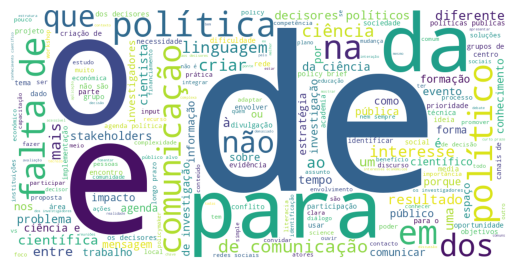

In [ ]:
prepocessed_string = (" ").join(list(chain(*preprocessed_list)))
wc = WordCloud(width = 1000, height = 500, background_color='white').generate(prepocessed_string)
plt.axis('off')
plt.imshow(wc)

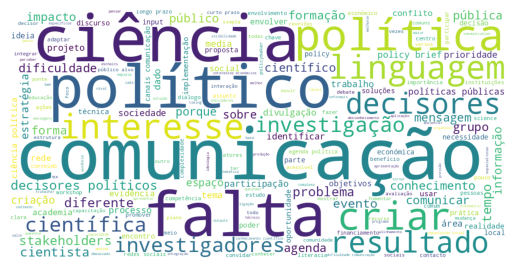

In [ ]:
normal_preprocessing_string = (" ").join(list(chain(*normal_preprocessing_list)))
wc = WordCloud(width = 1000, height = 500, background_color='white').generate(normal_preprocessing_string)
plt.axis('off')
plt.imshow(wc)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
print(preprocessed_list)

[['informação', 'muito', 'complexa', 'específica'], ['linguagem', 'usada'], ['informação', 'complexa'], ['complexidade', 'dos', 'resultados', 'obtidos'], ['pode', 'ser', 'muito', 'técnica', 'e', 'não', 'considerar', 'aspetos', 'sociais'], ['porque', 'o', 'input', 'não', 'é', 'oportuno'], ['os', 'investigadores', 'não', 'querem', 'passar', 'a', 'mensagem'], ['foco', 'nos', 'pormenores', 'falta', 'de', 'abrangência'], ['falta', 'integração', 'ciência', 'sociedade'], ['linguagem', 'inadequada'], ['imagem', 'pouco', 'apelativa'], ['serem', 'inconclusivos'], ['porque', 'a', 'ciência', 'em', 'geral', 'aceita', 'a', 'distinção', 'errada', 'entre', 'valores', 'e', 'factos'], ['falta', 'de', 'intervenção', 'participação', 'dos', 'cientistas'], ['porque', 'a', 'ciência', 'não', 'aparece', 'representada', 'no', 'seu', 'conjunto', 'só', 'por', 'uma', 'visão', 'entre', 'várias'], ['devido', 'à', 'linguagem', 'pouco', 'acessível', 'da', 'ciência', 'ou', 'de', 'alguma', 'ciência'], ['por', 'falta', '

In [ ]:
preprocessed = [ ' '.join(words) for words in preprocessed_list ]
print(preprocessed)

['informação muito complexa específica', 'linguagem usada', 'informação complexa', 'complexidade dos resultados obtidos', 'pode ser muito técnica e não considerar aspetos sociais', 'porque o input não é oportuno', 'os investigadores não querem passar a mensagem', 'foco nos pormenores falta de abrangência', 'falta integração ciência sociedade', 'linguagem inadequada', 'imagem pouco apelativa', 'serem inconclusivos', 'porque a ciência em geral aceita a distinção errada entre valores e factos', 'falta de intervenção participação dos cientistas', 'porque a ciência não aparece representada no seu conjunto só por uma visão entre várias', 'devido à linguagem pouco acessível da ciência ou de alguma ciência', 'por falta de clarezaeficiência do próprio discurso científico', 'dificuldade na transformação dos outputs em conteúdo entendível pelos decisores', 'acesso difícil ao leigo', 'foco disciplinar não holístico e abrangente', 'conteúdos muito específicos', 'isolamento da academia', 'dificuldad

In [ ]:
def ngram_wordcloud(text, n):
  vectorizer = CountVectorizer(ngram_range=(n, n))
  X = vectorizer.fit_transform(preprocessed)

  ngram_freqs = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
  cleaned_dict = {k: int(v) for k, v in ngram_freqs.items()}
  print(max(cleaned_dict.items(), key=lambda x: x[1]))
  wc = WordCloud(width=1500, height=800, background_color='white', collocations=False)
  wc.generate_from_frequencies(cleaned_dict)


  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()

### Bigrams

('falta de', 98)


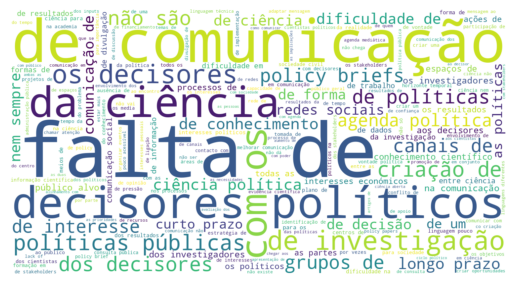

In [ ]:
ngram_wordcloud(preprocessed, 2)

### Trigrams

('canais de comunicação', 12)


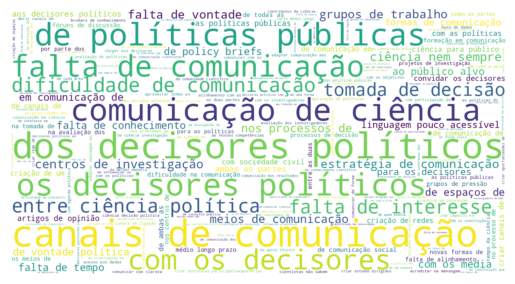

In [ ]:
ngram_wordcloud(preprocessed, 3)

## Find number of topics

### Using TFIDF

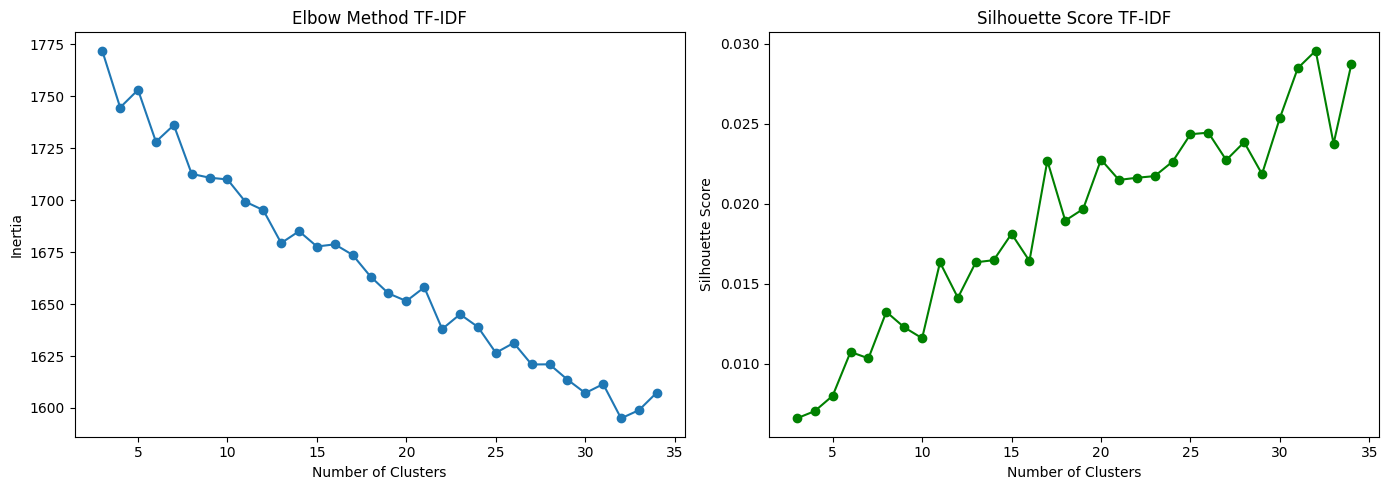

In [ ]:
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(preprocessed)

inertias = []
scores = []

for i in range(3,35):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_tfidf)
    inertias.append(kmeans.inertia_)
    labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels)
    scores.append(score)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(range(3, 35), inertias, marker='o')
axes[0].set_title('Elbow Method TF-IDF')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')

# Silhouette plot
axes[1].plot(range(3, 35), scores, marker='o', color='green')
axes[1].set_title('Silhouette Score TF-IDF')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

### Using Bag of Words

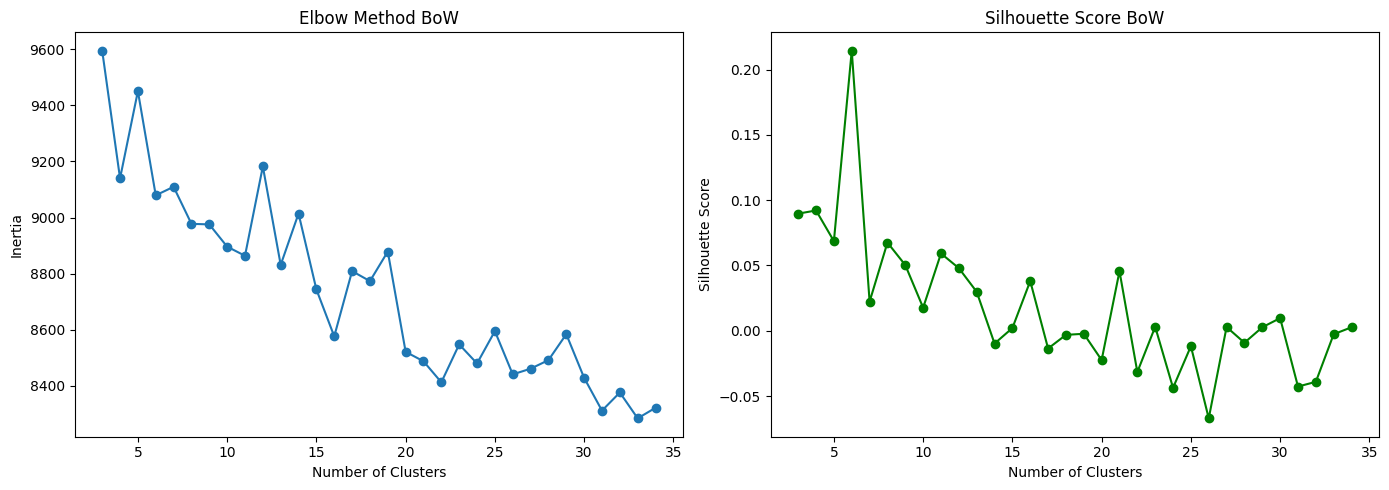

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(preprocessed)
inertias = []
scores = []

for i in range(3,35):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(range(3, 35), inertias, marker='o')
axes[0].set_title('Elbow Method BoW')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')

# Silhouette plot
axes[1].plot(range(3, 35), scores, marker='o', color='green')
axes[1].set_title('Silhouette Score BoW')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
def stem(text_list):
  stemmed_text = []
  for text in preprocessed_list:
    text = stemming(text)
    stemmed_text.append(text)
  return stemmed_text

stemmed_list = stem(preprocessed_list)



In [ ]:
def lemmatize(text_list):
  lemmatized_text = []
  for text in preprocessed_list:
    text = lemmatizing(text)
    lemmatized_text.append(text)
  return lemmatized_text

lemmatized_text = lemmatize(preprocessed_list)

In [ ]:
print(lemmatized_text)

[['informação', 'muito', 'complexo', 'específico'], ['linguagem', 'usar'], ['informação', 'complexo'], ['complexidade', 'de o', 'resultado', 'obter'], ['poder', 'ser', 'muito', 'técnica', 'e', 'não', 'considerar', 'aspeto', 'social'], ['porque', 'o', 'input', 'não', 'ser', 'oportuno'], ['o', 'investigador', 'não', 'querer', 'passar', 'a', 'mensagem'], ['foco', 'em o', 'pormenor', 'falta', 'de', 'abrangência'], ['falta', 'integração', 'ciência', 'sociedade'], ['linguagem', 'inadequar'], ['imagem', 'pouco', 'apelativo'], ['ser', 'inconclusivo'], ['porque', 'a', 'ciência', 'em', 'geral', 'aceitar', 'a', 'distinção', 'errar', 'entre', 'valor', 'e', 'facto'], ['falta', 'de', 'intervenção', 'participação', 'de o', 'cientista'], ['porque', 'a', 'ciência', 'não', 'aparecer', 'representar', 'em o', 'seu', 'conjunto', 'só', 'por', 'um', 'visão', 'entre', 'várias'], ['devido', 'a o', 'linguagem', 'pouco', 'acessível', 'de o', 'ciência', 'ou', 'de', 'algum', 'ciência'], ['por', 'falta', 'de', 'cla

# Data Preparation

In [ ]:
no_preprocessing =  text_list

simple_preprocessing = [" ".join(doc) for doc in simple_preprocessing_list]

normal_preprocessing = [" ".join(doc) for doc in normal_preprocessing_list]

total_preprocessing = [" ".join(doc) for doc in total_preprocessing_list]


In [ ]:
datasets = [no_preprocessing, simple_preprocessing, normal_preprocessing, total_preprocessing]

for dataset in datasets:
  print(len(dataset))
  print(mean(dataset))

1810
5.8762430939226515
1810
5.892265193370166
1810
4.075690607734806
1810
4.077900552486188


#Modeling

In [ ]:
topic_model = BERTopic(language="multilingual", min_topic_size=25)
docs = [" ".join(doc) for doc in lemmatized_text]
topics, probs = topic_model.fit_transform(docs)

In [ ]:
topic_model.get_topic_info()

Topic  Count                                       Name  \
0      -1    407                      -1_de_para_público_em   
1       0    400                          0_de_não_em_prazo   
2       1    188        1_político_política_público_decisor   
3       2    153                 2_ciência_científico_de_em   
4       3    132            3_comunicação_mensagem_canal_de   
5       4     88      4_ciência_política_político_cientista   
6       5     78  5_económico_dinheiro_financiamento_social   
7       6     59    6_linguagem_diferente_acessível_técnica   
8       7     52      7_comunicação_dificuldade_falta_canal   
9       8     51        8_investigação_de_investigador_dado   
10      9     48      9_stakeholder_instituição_de_entidade   
11     10     42             10_media_mediático_meio_social   
12     11     29      11_evento_organizar_concurso_informal   
13     12     28  12_complexidade_informação_complexo_muito   
14     13     28            13_rede_social_networking_criar   
15     14     27        14_policy_briefs_brief_policymakers   

                                       Representation  \
0   [de, para, público, em, falta, criar, investig...   
1   [de, não, em, prazo, falta, problema, ser, com...   
2   [político, política, público, decisor, de, age...   
3   [ciência, científico, de, em, cientista, ser, ...   
4   [comunicação, mensagem, canal, de, contacto, c...   
5   [ciência, política, político, cientista, cient...   
6   [económico, dinheiro, financiamento, social, i...   
7   [linguagem, diferente, acessível, técnica, pou...   
8   [comunicação, dificuldade, falta, canal, trans...   
9   [investigação, de, investigador, dado, acesso,...   
10  [stakeholder, instituição, de, entidade, mapea...   
11  [media, mediático, meio, social, comunicação, ...   
12  [evento, organizar, concurso, informal, event,...   
13  [complexidade, informação, complexo, muito, in...   
14  [rede, social, networking, criar, plataforma, ...   
15  [policy, briefs, brief, policymakers, escrever...   

                                  Representative_Docs  
0   [falta de conhecimento, formação para investig...  
1   [falta de disponibilidade para mudança mais a ...  
2   [interesse político, interesse político, falta...  
3   [linguagem científico, dificuldade de comunica...  
4             [comunicação, comunicação, comunicação]  
5   [formação política público para cientista, dif...  
6         [interesse económico, económico, económico]  
7                   [linguagem, linguagem, linguagem]  
8   [falta de comunicação, dificuldade de comunica...  
9   [criar mecanismo para facilitar a recolha de d...  
10  [identificação de stakeholder, identificação d...  
11  [melhorar a comunicação com o media, colaborar...  
12      [evento participar organizar, evento, evento]  
13  [informação muito complexo específico, informa...  
14  [criação de rede, criar conteúdo em o rede soc...  
15  [workshop de policy Briefs, formação policy Br...

In [ ]:
from sklearn.cluster import KMeans
n_topics = [5, 10, 15, 20]

def run_bertopic(sentence_model, lang, docs, n_topics = [5, 10, 15, 20]):

  results = {}
  embeddings = sentence_model.embed(docs)

  for n in n_topics:
    print(f"\n{'='*30}\nNúmero de tópicos: {n}\n{'='*30}")

    # Initialize KMeans and get cluster labels
    kmeans_model = KMeans(n_clusters=n, random_state=42)
    labels = kmeans_model.fit_predict(embeddings)

    # Calculate silhouette score
    sil_score = silhouette_score(embeddings, labels)
    print(f"Silhouette Score for {n} topics: {sil_score:.4f}")


    topic_model = BERTopic(
            embedding_model=sentence_model,
            language=lang,
            hdbscan_model=kmeans_model
        )
    topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
    topic_info = topic_model.get_topic_info()

    results[n] = (topic_info, sil_score)
    display(topic_info)



In [ ]:
from typing import List, Dict, Optional
import math

In [ ]:
def compute_entropy(word_scores):
    total = sum(score for _, score in word_scores)
    probs = [score / total for _, score in word_scores if score > 0]
    return -sum(p * math.log2(p) for p in probs)

In [ ]:
from typing import Dict, List, Optional
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from IPython.display import display

def run_bertopic_experiments(
    preprocessed_sets: Dict[str, List[str]],
    models: Dict[str, Optional[object]],
    n_topics: List[int] = [5, 10, 15, 20],
    lang: str = "multilingual"
) -> Dict[str, Dict[int, object]]:

    results = {}

    for prep_name, docs in preprocessed_sets.items():
        print(f"\n{'#'*60}\nPreprocessing: {prep_name}\n{'#'*60}")
        prep_results = {}

        for model_name, sentence_model in models.items():
            print(f"\nModel: {model_name}")
            model_results = {}

            embeddings = sentence_model.encode(docs, show_progress_bar=False)

            for n in n_topics:
                print(f"  → Num topics: {n}")
                kmeans_model = KMeans(n_clusters=n, random_state=42)

                topic_model = BERTopic(
                    embedding_model=sentence_model,
                    language=lang,
                    hdbscan_model=kmeans_model
                )

                topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
                topic_info = topic_model.get_topic_info()

                topic_entropies = {}

                for topic_id in topic_info['Topic']:
                    if topic_id == -1:  # Skip outlier topic
                        continue
                    top_words_scores = topic_model.get_topic(topic_id)[:10]
                    entropy = compute_entropy(top_words_scores)
                    topic_entropies[topic_id] = entropy
                    print(f"Topic {topic_id} Entropy: {entropy:.4f}")


                # Filter out -1 topics (outliers)
                valid_indices = [i for i, t in enumerate(topics) if t != -1]
                filtered_embeddings = [embeddings[i] for i in valid_indices]
                filtered_topics = [topics[i] for i in valid_indices]

                # Silhouette Score based on BERTopic topics
                if len(set(filtered_topics)) > 1:
                    sil_score = silhouette_score(filtered_embeddings, filtered_topics, metric="cosine")
                    print(f"Silhouette Score (BERTopic topics): {sil_score:.4f}")
                else:
                    sil_score = None
                    print("⚠️ Not enough distinct topics for silhouette score (after removing outliers).")

                model_results[n] = {
                    "topic_model": topic_model,
                    "topic_info": topic_info,
                    "topics": topics,
                    "silhouette_score": sil_score,
                    "entropy": topic_entropies

                }

                display(topic_info)

            prep_results[model_name] = model_results

        results[prep_name] = prep_results

    return results

In [ ]:
from sentence_transformers import SentenceTransformer, models

In [ ]:
def create_custom_sentence_model(model_name: str) -> SentenceTransformer:
    word_embedding_model = models.Transformer(model_name)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    return SentenceTransformer(modules=[word_embedding_model, pooling_model])

## BERTopic Experiments

In [ ]:
preprocessed_sets = {
    "no_preprocessing": no_preprocessing,
    "simple": simple_preprocessing,
    "normal": normal_preprocessing,
    "total": total_preprocessing
}

# Sentence models
pt_model = create_custom_sentence_model("PORTULAN/albertina-ptpt-base")
models = {
    "albertina": pt_model,
    "default": SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
}

# Run and save results
results = run_bertopic_experiments(preprocessed_sets, models)



############################################################
Preprocessing: no_preprocessing
############################################################

Model: albertina
  → Num topics: 5
Topic 0 Entropy: 3.2591
Topic 1 Entropy: 3.1366
Topic 2 Entropy: 3.1465
Topic 3 Entropy: 2.9587
Topic 4 Entropy: 3.3012
Silhouette Score (BERTopic topics): 0.0396


Topic  Count                                Name  \
0      0    664              0_de_os_para_políticos   
1      1    568  1_de_linguagem_resultados_mensagem   
2      2    270          2_ciência_da_de_científica   
3      3    201       3_comunicação_de_falta_canais   
4      4    107                    4_of_with_and_to   

                                      Representation  \
0  [de, os, para, políticos, com, decisores, não,...   
1  [de, linguagem, resultados, mensagem, com, pra...   
2  [ciência, da, de, científica, política, não, p...   
3  [comunicação, de, falta, canais, redes, sociai...   
4  [of, with, and, to, policy, science, communica...   

                                 Representative_Docs  
0  [Grupo de trabalho para as políticas públicas ...  
1  [Linguagem pouco acessível, Falta de foco no l...  
2  [Complexidade da comunicação em ciência, Dific...  
3  [Falta de comunicação, Falta de comunicação, F...  
4  [Targeting strategy to deal with policy-makers...

  → Num topics: 10
Topic 0 Entropy: 3.2663
Topic 1 Entropy: 3.2327
Topic 2 Entropy: 3.0810
Topic 3 Entropy: 3.2586
Topic 4 Entropy: 3.1012
Topic 5 Entropy: 3.1956
Topic 6 Entropy: 3.2207
Topic 7 Entropy: 3.2062
Topic 8 Entropy: 3.3021
Topic 9 Entropy: 2.9190
Silhouette Score (BERTopic topics): 0.0141


Topic  Count                                      Name  \
0      0    340        0_de_prazo_resultados_complexidade   
1      1    215                       1_de_para_criar_com   
2      2    207             2_comunicação_de_falta_canais   
3      3    194  3_políticas_interesses_públicas_política   
4      4    184                  4_ciência_da_política_de   
5      5    168                          5_não_que_são_os   
6      6    166  6_de_diferentes_estratégia_identificação   
7      7    131              7_decisores_políticos_os_com   
8      8    106                          8_of_with_and_to   
9      9     99    9_linguagem_mensagem_acessível_técnica   

                                      Representation  \
0  [de, prazo, resultados, complexidade, eventos,...   
1  [de, para, criar, com, em, os, investigação, m...   
2  [comunicação, de, falta, canais, redes, dificu...   
3  [políticas, interesses, públicas, política, pú...   
4  [ciência, da, política, de, científica, cientí...   
5  [não, que, são, os, porque, do, ao, da, cienti...   
6  [de, diferentes, estratégia, identificação, ce...   
7  [decisores, políticos, os, com, investigadores...   
8  [of, with, and, to, policy, science, communica...   
9  [linguagem, mensagem, acessível, técnica, ling...   

                                 Representative_Docs  
0  [Regularidade das ações no tempo a longo prazo...  
1  [(intra) Co-criação do conhecimento de outputs...  
2  [Falta de comunicação, Falta de comunicação, F...  
3  [Interesses políticos, Interesses políticos, A...  
4  [Falta de consciência da importância da ciênci...  
5  [Porque às vezes as medidas propostas pela ciê...  
6  [Melhoria na estratégia de comunicação nos cen...  
7  [As prioridades dos decisores políticos, Convi...  
8  [Targeting strategy to deal with policy-makers...  
9                  [Linguagem, Linguagem, Linguagem]

  → Num topics: 15
Topic 0 Entropy: 3.3012
Topic 1 Entropy: 3.2801
Topic 2 Entropy: 3.0875
Topic 3 Entropy: 3.2400
Topic 4 Entropy: 3.1982
Topic 5 Entropy: 3.1367
Topic 6 Entropy: 3.2644
Topic 7 Entropy: 3.2363
Topic 8 Entropy: 3.3026
Topic 9 Entropy: 2.9175
Topic 10 Entropy: 3.2257
Topic 11 Entropy: 3.0873
Topic 12 Entropy: 3.1789
Topic 13 Entropy: 3.0200
Topic 14 Entropy: 3.0376
Silhouette Score (BERTopic topics): 0.0159


Topic  Count                                         Name  \
0       0    243         0_eventos_de_resultados_complexidade   
1       1    228                             1_de_para_os_com   
2       2    188                2_comunicação_falta_de_canais   
3       3    162        3_de_identificação_instituições_ações   
4       4    127                        4_não_são_público_que   
5       5    125                  5_ciência_política_da_entre   
6       6    125      6_políticos_político_política_decisores   
7       7    115          7_ciência_científica_da_comunicação   
8       8    106                             8_of_with_and_to   
9       9     86     9_linguagem_mensagem_acessível_mensagens   
10     10     83          10_de_estratégia_investigação_criar   
11     11     74             11_públicas_pública_políticas_de   
12     12     60              12_prazo_longo_curto_económicas   
13     13     49  13_interesses_económicos_interesse_conflito   
14     14     39           14_diferentes_partes_linguagens_as   

                                       Representation  \
0   [eventos, de, resultados, complexidade, pressã...   
1   [de, para, os, com, decisores, criar, mais, do...   
2   [comunicação, falta, de, canais, redes, financ...   
3   [de, identificação, instituições, ações, dos, ...   
4   [não, são, público, que, alvo, porque, ao, os,...   
5   [ciência, política, da, entre, não, falta, cie...   
6   [políticos, político, política, decisores, pol...   
7   [ciência, científica, da, comunicação, investi...   
8   [of, with, and, to, science, policy, communica...   
9   [linguagem, mensagem, acessível, mensagens, té...   
10  [de, estratégia, investigação, criar, comunica...   
11  [públicas, pública, políticas, de, participaçã...   
12  [prazo, longo, curto, económicas, razões, impa...   
13  [interesses, económicos, interesse, conflito, ...   
14  [diferentes, partes, linguagens, as, motivaçõe...   

                                  Representative_Docs  
0             [Eventos, Eventos, Networking: eventos]  
1   [Não desistir de comunicar os resultados do me...  
2   [Falta de comunicação, Falta de comunicação, F...  
3   [Identificação de stakeholders, Identificação ...  
4   [A mensagem não chega ao público-alvo da melho...  
5   [Diferentes prazo entre a ciência e a decisão ...  
6   [Falta de abertura por parte dos decisores pol...  
7   [Dificuldade de comunicação dos resultados em ...  
8   [There is a need of discussion forums that inc...  
9                   [Linguagem, Linguagem, Linguagem]  
10  [Melhoria na estratégia de comunicação nos cen...  
11  [As políticas públicas ambientais não são poss...  
12  [Económicas – custo (a curto prazo), Conflito ...  
13  [Interesses, Interesses económicos, Interesses...  
14  [Linguagens diferentes, Linguagens diferentes,...

  → Num topics: 20
Topic 0 Entropy: 3.2632
Topic 1 Entropy: 3.2804
Topic 2 Entropy: 3.2988
Topic 3 Entropy: 3.2353
Topic 4 Entropy: 3.3029
Topic 5 Entropy: 3.2546
Topic 6 Entropy: 3.2954
Topic 7 Entropy: 3.1342
Topic 8 Entropy: 2.9965
Topic 9 Entropy: 3.3068
Topic 10 Entropy: 3.2984
Topic 11 Entropy: 3.0457
Topic 12 Entropy: 3.2920
Topic 13 Entropy: 3.1359
Topic 14 Entropy: 3.0423
Topic 15 Entropy: 3.0946
Topic 16 Entropy: 3.1330
Topic 17 Entropy: 3.1746
Topic 18 Entropy: 3.1565
Topic 19 Entropy: 2.9091
Silhouette Score (BERTopic topics): 0.0198


Topic  Count                                            Name  \
0       0    206                    0_de_criar_para_investigação   
1       1    201        1_políticos_políticas_decisores_públicas   
2       2    141                   2_media_pressão_grupos_broker   
3       3    108            3_diferentes_de_identificação_partes   
4       4    106                                4_of_with_and_to   
5       5     92                       5_ciência_não_política_da   
6       6     92                     6_com_eventos_os_resultados   
7       7     90                                7_não_são_que_os   
8       8     88                  8_ciência_da_política_ausência   
9       9     85       9_científica_científico_para_investigação   
10     10     81           10_de_formação_informação_comunicação   
11     11     80             11_comunicação_canais_sociais_redes   
12     12     74    12_complexidade_eventos_escuta_incompreensão   
13     13     73     13_linguagem_comunicar_científica_vantagens   
14     14     56     14_interesses_económicos_interesse_conflito   
15     15     54       15_falta_financiamento_desconhecimento_de   
16     16     49                     16_mensagem_público_alvo_ao   
17     17     48  17_dificuldade_comunicação_prioridades_difícil   
18     18     47                 18_prazo_longo_curto_económicas   
19     19     39            19_linguagem_acessível_técnica_pouco   

                                       Representation  \
0   [de, criar, para, investigação, em, os, estrat...   
1   [políticos, políticas, decisores, públicas, po...   
2   [media, pressão, grupos, broker, burocracia, f...   
3   [diferentes, de, identificação, partes, instit...   
4   [of, with, and, to, science, communication, po...   
5   [ciência, não, política, da, entre, político, ...   
6   [com, eventos, os, resultados, encontros, stak...   
7   [não, são, que, os, pouco, porque, querem, as,...   
8   [ciência, da, política, ausência, de, importân...   
9   [científica, científico, para, investigação, d...   
10  [de, formação, informação, comunicação, criaçã...   
11  [comunicação, canais, sociais, redes, social, ...   
12  [complexidade, eventos, escuta, incompreensão,...   
13  [linguagem, comunicar, científica, vantagens, ...   
14  [interesses, económicos, interesse, conflito, ...   
15  [falta, financiamento, desconhecimento, de, al...   
16  [mensagem, público, alvo, ao, pensar, empatia,...   
17  [dificuldade, comunicação, prioridades, difíci...   
18  [prazo, longo, curto, económicas, razões, fina...   
19  [linguagem, acessível, técnica, pouco, linguag...   

                                  Representative_Docs  
0   [Organizar eventos e participar em momentos qu...  
1   [Alinhamento com as políticas do governo (deci...  
2   [Aparecer nos media (social media press entrev...  
3   [Diferentes linguagens para diferentes público...  
4   [There is a need of discussion forums that inc...  
5   [Diferentes prazo entre a ciência e a decisão ...  
6   [Criar estudos dirigidos aos problemas PP, Cri...  
7   [Não dá votos ou não se adequa à vontade polít...  
8   [Complexidade da comunicação em ciência, Falta...  
9   [Falha na tradução do impacto da investigação ...  
10  [Criação de redes, Informação complexa, Inform...  
11           [Comunicação;, Comunicação, Comunicação]  
12         [Escuta ativa, Escuta ativa, Escuta ativa]  
13  [Linguagem científica é difícil, Linguagem cie...  
14  [Interesses, Interesses económicos, Interesses...  
15  [Falta de comunicação, Falta de comunicação, F...  
16  [Adequar mensagem ao decisor alvo, Dificuldade...  
17  [Dificuldade na comunicação, Dificuldade de co...  
18  [Conflito entre longo e curto prazo, Objetivos...  
19                  [Linguagem, Linguagem, Linguagem]


Model: default
  → Num topics: 5
Topic 0 Entropy: 3.2063
Topic 1 Entropy: 3.2449
Topic 2 Entropy: 3.2281
Topic 3 Entropy: 3.2997
Topic 4 Entropy: 2.9932
Silhouette Score (BERTopic topics): 0.0894


Topic  Count                             Name  \
0      0    480         0_de_linguagem_falta_não   
1      1    396          1_de_decisores_com_para   
2      2    340   2_ciência_de_da_investigadores   
3      3    339     3_de_agenda_interesses_prazo   
4      4    255  4_comunicação_de_media_mensagem   

                                      Representation  \
0  [de, linguagem, falta, não, resultados, da, co...   
1  [de, decisores, com, para, stakeholders, polít...   
2  [ciência, de, da, investigadores, científica, ...   
3  [de, agenda, interesses, prazo, política, polí...   
4  [comunicação, de, media, mensagem, canais, red...   

                                 Representative_Docs  
0  [Falta de conhecimento, Falta de conhecimento,...  
1  [Comunicar com os políticos (organizar grupos ...  
2  [Falta de interesse da política nos contributo...  
3  [Interesses económicos virados para o curto pr...  
4            [Comunicação, Comunicação, Comunicação]

  → Num topics: 10
Topic 0 Entropy: 3.2466
Topic 1 Entropy: 3.2091
Topic 2 Entropy: 3.2809
Topic 3 Entropy: 3.2869
Topic 4 Entropy: 2.9210
Topic 5 Entropy: 3.2329
Topic 6 Entropy: 3.2034
Topic 7 Entropy: 3.2271
Topic 8 Entropy: 3.2484
Topic 9 Entropy: 2.7786
Silhouette Score (BERTopic topics): 0.0877


Topic  Count                                            Name  \
0      0    323                     0_falta_de_não_conhecimento   
1      1    284                      1_ciência_científica_da_de   
2      2    279                      2_de_com_decisores_eventos   
3      3    213                     3_de_resultados_prazo_tempo   
4      4    191             4_comunicação_mensagem_de_comunicar   
5      5    155            5_políticos_agenda_política_político   
6      6    148             6_investigação_stakeholders_de_para   
7      7     81                7_media_redes_canais_comunicação   
8      8     73  8_económicos_financiamento_dinheiro_interesses   
9      9     63     9_linguagem_linguagens_diferentes_acessível   

                                      Representation  \
0  [falta, de, não, conhecimento, informação, da,...   
1  [ciência, científica, da, de, política, cienti...   
2  [de, com, decisores, eventos, policy, política...   
3  [de, resultados, prazo, tempo, longo, interess...   
4  [comunicação, mensagem, de, comunicar, dificul...   
5  [políticos, agenda, política, político, intere...   
6  [investigação, stakeholders, de, para, dos, in...   
7  [media, redes, canais, comunicação, sociais, d...   
8  [económicos, financiamento, dinheiro, interess...   
9  [linguagem, linguagens, diferentes, acessível,...   

                                 Representative_Docs  
0  [Falta de formação, Falta de conhecimento, Fal...  
1  [Falta de interesse da política nos contributo...  
2  [Criar eventos e convidar decisores, Alinhamen...  
3  [Conflito entre longo e curto prazo, Falta de ...  
4            [Comunicação, Comunicação, Comunicação]  
5  [Interesses políticos, Interesses políticos, F...  
6  [Envolvimento de stakeholders, Projetos de inv...  
7  [Falta de canais de comunicação, Criar canais ...  
8  [Pressões de interesses económicos/corrupção, ...  
9                  [Linguagem, Linguagem, Linguagem]

  → Num topics: 15
Topic 0 Entropy: 3.2903
Topic 1 Entropy: 3.0461
Topic 2 Entropy: 3.1907
Topic 3 Entropy: 3.2712
Topic 4 Entropy: 3.2363
Topic 5 Entropy: 3.2581
Topic 6 Entropy: 3.2523
Topic 7 Entropy: 3.2491
Topic 8 Entropy: 3.2239
Topic 9 Entropy: 3.1865
Topic 10 Entropy: 3.1558
Topic 11 Entropy: 3.2523
Topic 12 Entropy: 2.8049
Topic 13 Entropy: 3.0365
Topic 14 Entropy: 3.1757
Silhouette Score (BERTopic topics): 0.0797


Topic  Count                                             Name  \
0       0    250                     0_interesses_problemas_de_do   
1       1    165                1_comunicação_mensagem_de_público   
2       2    163               2_ciência_científica_científico_da   
3       3    154                   3_resultados_prazo_longo_tempo   
4       4    142                     4_policy_políticas_briefs_de   
5       5    129              5_falta_conhecimento_não_informação   
6       6    126             6_políticos_político_agenda_política   
7       7    122                7_decisores_eventos_políticos_com   
8       8    120               8_política_ciência_políticos_entre   
9       9    104               9_stakeholders_atores_workshops_de   
10     10     89           10_investigação_de_investigadores_para   
11     11     73  11_económicos_financiamento_dinheiro_económicas   
12     12     64     12_linguagem_linguagens_diferentes_acessível   
13     13     55           13_comunicação_canais_networking_falta   
14     14     54                     14_media_redes_sociais_meios   

                                       Representation  \
0   [interesses, problemas, de, do, empatia, soluç...   
1   [comunicação, mensagem, de, público, comunicar...   
2   [ciência, científica, científico, da, de, cien...   
3   [resultados, prazo, longo, tempo, de, curto, i...   
4   [policy, políticas, briefs, de, públicas, impl...   
5   [falta, conhecimento, não, informação, de, com...   
6   [políticos, político, agenda, política, não, i...   
7   [decisores, eventos, políticos, com, de, decis...   
8   [política, ciência, políticos, entre, investig...   
9   [stakeholders, atores, workshops, de, criar, i...   
10  [investigação, de, investigadores, para, dados...   
11  [económicos, financiamento, dinheiro, económic...   
12  [linguagem, linguagens, diferentes, acessível,...   
13  [comunicação, canais, networking, falta, de, r...   
14  [media, redes, sociais, meios, mediática, soci...   

                                  Representative_Docs  
0   [Interesses, Criar empatia, procurar o ponto e...  
1            [Comunicação, Comunicação;, Comunicação]  
2   [Complexidade da comunicação em ciência, Dific...  
3   [Propor soluções que tenham impacto, em conjun...  
4   [Formação - Policy briefs, Policy briefs, Grup...  
5   [Falta de conhecimento da realidade, Falta de ...  
6   [Interesses políticos, Interesses políticos, I...  
7   [Criar eventos e convidar decisores, Convidar ...  
8   [Programas de capacitação (políticos - ciência...  
9   [Identificação de stakeholders, Promover encon...  
10  [Criar mecanismos para facilitar a recolha de ...  
11  [Pressões de interesses económicos/corrupção, ...  
12                  [Linguagem, Linguagem, Linguagem]  
13  [Falta de canais de comunicação (Política), Ca...  
14  [Aparecer nos media (social media press entrev...

  → Num topics: 20
Topic 0 Entropy: 3.2750
Topic 1 Entropy: 3.1899
Topic 2 Entropy: 3.0544
Topic 3 Entropy: 3.2638
Topic 4 Entropy: 3.2677
Topic 5 Entropy: 3.2150
Topic 6 Entropy: 3.2363
Topic 7 Entropy: 3.2704
Topic 8 Entropy: 3.2263
Topic 9 Entropy: 3.1558
Topic 10 Entropy: 3.2078
Topic 11 Entropy: 3.1858
Topic 12 Entropy: 3.2552
Topic 13 Entropy: 2.8294
Topic 14 Entropy: 3.1379
Topic 15 Entropy: 3.1499
Topic 16 Entropy: 3.0926
Topic 17 Entropy: 3.1467
Topic 18 Entropy: 3.0951
Topic 19 Entropy: 3.1872
Silhouette Score (BERTopic topics): 0.0734


Topic  Count                                              Name  \
0       0    211          0_interesses_problemas_soluções_educação   
1       1    142           1_stakeholders_eventos_atores_workshops   
2       2    137         2_comunicação_mensagem_discurso_comunicar   
3       3    132                    3_prazo_resultados_longo_curto   
4       4    122                 4_policy_políticas_briefs_decisão   
5       5    117                         5_falta_não_realidade_são   
6       6    115                  6_políticos_decisores_grupos_com   
7       7    114              7_agenda_política_políticos_político   
8       8    109                8_política_ciência_políticos_entre   
9       9     91             9_investigação_investigadores_de_para   
10     10     87                      10_ciência_da_não_científica   
11     11     83      11_científica_ciência_comunicação_científico   
12     12     73   12_económicos_financiamento_dinheiro_económicas   
13     13     64      13_linguagem_linguagens_diferentes_acessível   
14     14     50  14_conhecimento_complexidade_informação_complexa   
15     15     41                   15_media_meios_mediática_social   
16     16     40                16_redes_canais_sociais_networking   
17     17     32           17_público_confiança_transparência_alvo   
18     18     32              18_comunicação_falta_ineficaz_eficaz   
19     19     18                    19_tempo_time_tempos_horizonte   

                                       Representation  \
0   [interesses, problemas, soluções, educação, at...   
1   [stakeholders, eventos, atores, workshops, de,...   
2   [comunicação, mensagem, discurso, comunicar, d...   
3   [prazo, resultados, longo, curto, impacto, de,...   
4   [policy, políticas, briefs, decisão, de, decis...   
5   [falta, não, realidade, são, de, empatia, acad...   
6   [políticos, decisores, grupos, com, de, pressã...   
7   [agenda, política, políticos, político, intere...   
8   [política, ciência, políticos, entre, investig...   
9   [investigação, investigadores, de, para, dados...   
10  [ciência, da, não, científica, cientistas, cie...   
11  [científica, ciência, comunicação, científico,...   
12  [económicos, financiamento, dinheiro, económic...   
13  [linguagem, linguagens, diferentes, acessível,...   
14  [conhecimento, complexidade, informação, compl...   
15  [media, meios, mediática, social, jornalistas,...   
16  [redes, canais, sociais, networking, comunicaç...   
17  [público, confiança, transparência, alvo, mark...   
18  [comunicação, falta, ineficaz, eficaz, existe,...   
19  [tempo, time, tempos, horizonte, temporal, dif...   

                                  Representative_Docs  
0   [Interesses, Conflito de interesses, Conflito ...  
1   [Identificação de stakeholders, Promover encon...  
2            [Comunicação;, Comunicação, Comunicação]  
3   [Propor soluções que tenham impacto, em conjun...  
4   [Formação - Policy briefs, Policy briefs, Grup...  
5   [Falta de conhecimento, Falta de conhecimento,...  
6   [Organizar eventos e participar em momentos qu...  
7   [Interesses políticos, Interesses políticos, I...  
8   [Programas de capacitação (políticos - ciência...  
9   [Criar mecanismos para facilitar a recolha de ...  
10  [Não valorização da ciência, Falta de consciên...  
11  [Linguagem científica, Dificuldade na comunica...  
12  [Pressões de interesses económicos/corrupção, ...  
13                  [Linguagem, Linguagem, Linguagem]  
14         [Complexidade, Conhecimento, Conhecimento]  
15  [Colaborar com os Media e ter uma estratégia M...  
16  [Criar canais de comunicação, Canais de comuni...  
17  [Definição do público-alvo, Conhecer o público...  
18  [Falta de comunicação, Falta de comunicação, F...  
19                              [Tempo, Tempo, Tempo]


############################################################
Preprocessing: simple
############################################################

Model: albertina
  → Num topics: 5
Topic 0 Entropy: 3.2930
Topic 1 Entropy: 3.2261
Topic 2 Entropy: 3.1554
Topic 3 Entropy: 2.9775
Topic 4 Entropy: 3.2989
Silhouette Score (BERTopic topics): 0.0443


Topic  Count                              Name  \
0      0    612             0_de_não_políticos_os   
1      1    479    1_de_diferentes_resultados_com   
2      2    401      2_ciência_de_da_investigação   
3      3    201  3_comunicação_de_falta_linguagem   
4      4    117                  4_of_with_and_to   

                                      Representation  \
0  [de, não, políticos, os, para, com, decisores,...   
1  [de, diferentes, resultados, com, criar, dos, ...   
2  [ciência, de, da, investigação, científica, pa...   
3  [comunicação, de, falta, linguagem, canais, na...   
4  [of, with, and, to, policy, communication, pol...   

                                 Representative_Docs  
0  [formação para investigadores do med sobre com...  
1  [fazer encontros na academia com os stakeholde...  
2  [dificuldade na comunicação da ciência, falta ...  
3  [falta de comunicação, falta de comunicação, f...  
4  [there is a need of discussion forums that inc...

  → Num topics: 10
Topic 0 Entropy: 3.2879
Topic 1 Entropy: 3.2103
Topic 2 Entropy: 3.0764
Topic 3 Entropy: 3.2706
Topic 4 Entropy: 3.2931
Topic 5 Entropy: 3.0120
Topic 6 Entropy: 3.2182
Topic 7 Entropy: 3.2745
Topic 8 Entropy: 3.2999
Topic 9 Entropy: 2.8841
Silhouette Score (BERTopic topics): 0.0355


Topic  Count                                        Name  \
0      0    339  0_políticos_políticas_decisores_interesses   
1      1    277                  1_de_investigação_para_com   
2      2    228                  2_ciência_da_científica_de   
3      3    206       3_de_comunicação_diferentes_linguagem   
4      4    198                 4_resultados_prazo_com_para   
5      5    152               5_comunicação_falta_de_canais   
6      6    140                       6_não_mensagem_são_de   
7      7    125       7_eventos_complexidade_pressão_comuns   
8      8    108                            8_of_with_and_to   
9      9     37         9_linguagem_acessível_técnica_pouco   

                                      Representation  \
0  [políticos, políticas, decisores, interesses, ...   
1  [de, investigação, para, com, criar, as, em, o...   
2  [ciência, da, científica, de, política, cientí...   
3  [de, comunicação, diferentes, linguagem, ident...   
4  [resultados, prazo, com, para, os, longo, de, ...   
5  [comunicação, falta, de, canais, sociais, fina...   
6  [não, mensagem, são, de, ao, uma, para, proble...   
7  [eventos, complexidade, pressão, comuns, concu...   
8  [of, with, and, to, policy, communication, pol...   
9  [linguagem, acessível, técnica, pouco, linguag...   

                                 Representative_Docs  
0  [alinhamento com as políticas do governo decis...  
1  [melhoria na estratégia de comunicação nos cen...  
2  [falta de interesse da política nos contributo...  
3  [falamos línguas diferentes dificuldade de com...  
4  [por exigência de resultados a curto prazo, ob...  
5  [falta de comunicação, falta de comunicação, f...  
6  [porque a linguagem não é clara ou simples par...  
7                   [complexidade, eventos, eventos]  
8  [targeting strategy to deal with policy makers...  
9                  [linguagem, linguagem, linguagem]

  → Num topics: 15
Topic 0 Entropy: 3.2811
Topic 1 Entropy: 3.2578
Topic 2 Entropy: 3.2602
Topic 3 Entropy: 3.2471
Topic 4 Entropy: 3.2976
Topic 5 Entropy: 3.1881
Topic 6 Entropy: 3.0423
Topic 7 Entropy: 3.2535
Topic 8 Entropy: 3.0448
Topic 9 Entropy: 3.2703
Topic 10 Entropy: 3.1685
Topic 11 Entropy: 3.2975
Topic 12 Entropy: 3.2795
Topic 13 Entropy: 2.9096
Topic 14 Entropy: 2.3450
Silhouette Score (BERTopic topics): 0.0323


Topic  Count                                               Name  \
0       0    228                      0_não_políticos_decisores_que   
1       1    196                          1_de_investigação_para_as   
2       2    189                          2_resultados_com_criar_de   
3       3    163                   3_mensagem_diferentes_para_criar   
4       4    155            4_linguagem_identificação_de_informação   
5       5    140                   5_ciência_científica_política_da   
6       6    140                      6_comunicação_falta_de_canais   
7       7    115                    7_públicas_pública_políticas_de   
8       8     99                        8_ciência_da_de_comunicação   
9       9     88            9_eventos_concursos_mapeamento_dinheiro   
10     10     88               10_interesses_prazo_económicos_longo   
11     11     86                                  11_of_with_and_to   
12     12     78                    12_investigação_sociedade_de_na   
13     13     37          13_linguagem_acessível_técnica_linguagens   
14     14      8  14_financiamento_orçamento_financiamentoselos_...   

                                       Representation  \
0   [não, políticos, decisores, que, os, político,...   
1   [de, investigação, para, as, com, em, estratég...   
2   [resultados, com, criar, de, para, workshops, ...   
3   [mensagem, diferentes, para, criar, de, os, op...   
4   [linguagem, identificação, de, informação, com...   
5   [ciência, científica, política, da, científico...   
6   [comunicação, falta, de, canais, redes, sociai...   
7   [públicas, pública, políticas, de, políticos, ...   
8   [ciência, da, de, comunicação, científica, em,...   
9   [eventos, concursos, mapeamento, dinheiro, sta...   
10  [interesses, prazo, económicos, longo, curto, ...   
11  [of, with, and, to, policy, policymakers, is, ...   
12  [investigação, sociedade, de, na, brokers, aca...   
13  [linguagem, acessível, técnica, linguagens, po...   
14  [financiamento, orçamento, financiamentoselos,...   

                                  Representative_Docs  
0   [porque não são comunicados a decisores, alinh...  
1   [organizar eventos e participar em momentos qu...  
2   [mostrar resultados, fazer encontros na academ...  
3   [os cientistas têm dificuldade em explicar os ...  
4   [identificação de stakeholders, identificação ...  
5   [devido à linguagem pouco acessível da ciência...  
6   [falta de comunicação, falta de comunicação, f...  
7   [falta de motivação dos investigadores para a ...  
8   [falta de comunicação da parte da ciência, com...  
9            [eventos de brokerage, eventos, eventos]  
10  [interesses, interesses económicos, interesses...  
11  [targeting strategy to deal with policy makers...  
12  [integrar nos centros de investigação – knowle...  
13                  [linguagem, linguagem, linguagem]  
14      [financiamento, financiamento, financiamento]

  → Num topics: 20
Topic 0 Entropy: 3.2579
Topic 1 Entropy: 3.2477
Topic 2 Entropy: 3.2222
Topic 3 Entropy: 3.0903
Topic 4 Entropy: 3.1164
Topic 5 Entropy: 3.2510
Topic 6 Entropy: 3.2818
Topic 7 Entropy: 3.2904
Topic 8 Entropy: 3.1999
Topic 9 Entropy: 3.2956
Topic 10 Entropy: 3.1762
Topic 11 Entropy: 3.2783
Topic 12 Entropy: 3.2979
Topic 13 Entropy: 3.1725
Topic 14 Entropy: 3.1543
Topic 15 Entropy: 3.1295
Topic 16 Entropy: 3.2686
Topic 17 Entropy: 3.2357
Topic 18 Entropy: 2.9068
Topic 19 Entropy: 2.3384
Silhouette Score (BERTopic topics): 0.0206


Topic  Count                                               Name  \
0       0    161                       0_de_investigação_criar_para   
1       1    142               1_ciência_científica_da_investigação   
2       2    127                        2_resultados_criar_para_com   
3       3    124                      3_comunicação_falta_canais_de   
4       4    121                   4_ciência_política_da_científico   
5       5    120            5_políticos_política_político_decisores   
6       6    119                         6_decisores_com_os_espaços   
7       7    117                               7_não_são_que_porque   
8       8     99               8_públicas_pública_políticas_público   
9       9     95                    9_informação_de_complexa_escuta   
10     10     88               10_interesses_prazo_económicos_longo   
11     11     86        11_complexidade_concursos_mapeamento_grupos   
12     12     83                                  12_of_with_and_to   
13     13     74                       13_mensagem_não_público_para   
14     14     66            14_comunicação_linguagem_dificuldade_na   
15     15     58   15_diferentes_identificação_soluções_prioridades   
16     16     53                  16_eventos_ego_brokerage_incómodo   
17     17     42              17_acessível_linguagem_discurso_pouco   
18     18     27          18_linguagem_técnica_linguagens_demasiado   
19     19      8  19_financiamento_orçamento_financiamentoselos_...   

                                       Representation  \
0   [de, investigação, criar, para, as, estratégia...   
1   [ciência, científica, da, investigação, de, co...   
2   [resultados, criar, para, com, os, informais, ...   
3   [comunicação, falta, canais, de, redes, sociai...   
4   [ciência, política, da, científico, científica...   
5   [políticos, política, político, decisores, os,...   
6   [decisores, com, os, espaços, espaço, de, even...   
7   [não, são, que, porque, as, do, por, muito, po...   
8   [públicas, pública, políticas, público, de, pa...   
9   [informação, de, complexa, escuta, incompreens...   
10  [interesses, prazo, económicos, longo, curto, ...   
11  [complexidade, concursos, mapeamento, grupos, ...   
12  [of, with, and, to, policy, policymakers, is, ...   
13  [mensagem, não, público, para, são, ao, mensag...   
14  [comunicação, linguagem, dificuldade, na, mesm...   
15  [diferentes, identificação, soluções, priorida...   
16  [eventos, ego, brokerage, incómodo, time, mark...   
17  [acessível, linguagem, discurso, pouco, apelat...   
18  [linguagem, técnica, linguagens, demasiado, co...   
19  [financiamento, orçamento, financiamentoselos,...   

                                  Representative_Docs  
0   [projetos de investigação participativos – inv...  
1   [equilíbrio dos resultados de transferência de...  
2   [foco nos resultados, ajustar indicadores de r...  
3   [falta de comunicação, falta de comunicação, f...  
4   [falta de consciência da importância da ciênci...  
5   [falta de abertura por parte dos decisores pol...  
6   [convidar os decisores, criar eventos e convid...  
7   [pensar no que não deixa as políticas dormir e...  
8   [as políticas públicas ambientais não são poss...  
9   [mecanismos de avaliação monitorização dos imp...  
10  [interesses, interesses económicos, interesses...  
11         [complexidade, complexidade, complexidade]  
12  [targeting strategy to deal with policy makers...  
13  [adequação da mensagem ao público alvo, formaç...  
14  [dificuldade de comunicação, dificuldade na co...  
15  [tempos diferentes, diferentes linguagens para...  
16           [eventos de brokerage, eventos, eventos]  
17  [linguagem pouco acessível aos decisores, ling...  
18                  [linguagem, linguagem, linguagem]  
19      [financiamento, financiamento, financiamento]


Model: default
  → Num topics: 5
Topic 0 Entropy: 3.1906
Topic 1 Entropy: 3.2768
Topic 2 Entropy: 3.2340
Topic 3 Entropy: 3.2465
Topic 4 Entropy: 2.9216
Silhouette Score (BERTopic topics): 0.0971


Topic  Count                                 Name  \
0      0    461            0_de_falta_não_resultados   
1      1    406         1_de_políticos_políticas_com   
2      2    374         2_ciência_de_da_investigação   
3      3    345        3_de_stakeholders_com_eventos   
4      4    224  4_comunicação_linguagem_de_mensagem   

                                      Representation  \
0  [de, falta, não, resultados, da, prazo, inform...   
1  [de, políticos, políticas, com, agenda, políti...   
2  [ciência, de, da, investigação, investigadores...   
3  [de, stakeholders, com, eventos, para, criar, ...   
4  [comunicação, linguagem, de, mensagem, acessív...   

                                 Representative_Docs  
0  [falta de tempo, falta de tempo de implementaç...  
1  [interesses políticos, interesses políticos, f...  
2  [falta de interesse da política nos contributo...  
3  [falta de canais de comunicação, criar canais ...  
4            [comunicação, comunicação, comunicação]

  → Num topics: 10
Topic 0 Entropy: 3.2651
Topic 1 Entropy: 3.2634
Topic 2 Entropy: 3.1985
Topic 3 Entropy: 3.2674
Topic 4 Entropy: 3.2516
Topic 5 Entropy: 2.9092
Topic 6 Entropy: 3.2003
Topic 7 Entropy: 3.2505
Topic 8 Entropy: 2.7837
Topic 9 Entropy: 3.2210
Silhouette Score (BERTopic topics): 0.1024


Topic  Count                                            Name  \
0      0    287                     0_falta_de_não_conhecimento   
1      1    286                1_de_resultados_prazo_interesses   
2      2    279                      2_ciência_da_científica_de   
3      3    241               3_políticos_políticas_política_de   
4      4    208             4_de_stakeholders_eventos_decisores   
5      5    193                5_comunicação_de_canais_mensagem   
6      6    107           6_investigação_investigadores_de_para   
7      7     87  7_económicos_dinheiro_económicas_financiamento   
8      8     62     8_linguagem_linguagens_acessível_diferentes   
9      9     60                    9_media_redes_sociais_social   

                                      Representation  \
0  [falta, de, não, conhecimento, informação, com...   
1  [de, resultados, prazo, interesses, para, os, ...   
2  [ciência, da, científica, de, cientistas, polí...   
3  [políticos, políticas, política, de, agenda, p...   
4  [de, stakeholders, eventos, decisores, com, pa...   
5  [comunicação, de, canais, mensagem, comunicar,...   
6  [investigação, investigadores, de, para, dados...   
7  [económicos, dinheiro, económicas, financiamen...   
8  [linguagem, linguagens, acessível, diferentes,...   
9  [media, redes, sociais, social, meios, comunic...   

                                 Representative_Docs  
0  [falta de conhecimento da realidade, falta de ...  
1  [conflito entre longo e curto prazo, objetivos...  
2  [dificuldade de comunicação dos resultados em ...  
3  [grupo de trabalho para as políticas públicas ...  
4  [envolvimento de stakeholders, convidar os dec...  
5            [comunicação, comunicação, comunicação]  
6  [mais políticos na investigação, criar estrutu...  
7  [conflitos com interesses económicos, interess...  
8                  [linguagem, linguagem, linguagem]  
9  [aparecer nos media social media press entrevi...

  → Num topics: 15
Topic 0 Entropy: 3.2876
Topic 1 Entropy: 3.2714
Topic 2 Entropy: 3.2591
Topic 3 Entropy: 3.1957
Topic 4 Entropy: 3.3133
Topic 5 Entropy: 3.0322
Topic 6 Entropy: 3.2795
Topic 7 Entropy: 3.2280
Topic 8 Entropy: 3.2466
Topic 9 Entropy: 3.2622
Topic 10 Entropy: 3.1712
Topic 11 Entropy: 3.0801
Topic 12 Entropy: 3.2203
Topic 13 Entropy: 2.8266
Topic 14 Entropy: 3.1526
Silhouette Score (BERTopic topics): 0.0772


Topic  Count                                            Name  \
0       0    244            0_de_resultados_interesses_problemas   
1       1    207             1_falta_conhecimento_informação_não   
2       2    188             2_stakeholders_eventos_de_decisores   
3       3    172              3_ciência_científica_da_científico   
4       4    148                        4_de_agenda_público_alvo   
5       5    119             5_comunicação_mensagem_comunicar_de   
6       6    117            6_políticas_policy_pública_políticos   
7       7    116              7_política_ciência_políticos_entre   
8       8    113            8_política_políticos_político_agenda   
9       9     89  9_económicos_dinheiro_económicas_financiamento   
10     10     84          10_investigação_investigadores_de_para   
11     11     76             11_comunicação_canais_de_networking   
12     12     58                   12_media_redes_sociais_social   
13     13     57    13_linguagem_linguagens_acessível_diferentes   
14     14     22                14_dados_evidências_de_evidência   

                                       Representation  \
0   [de, resultados, interesses, problemas, intere...   
1   [falta, conhecimento, informação, não, complex...   
2   [stakeholders, eventos, de, decisores, com, at...   
3   [ciência, científica, da, científico, de, cien...   
4   [de, agenda, público, alvo, objetivos, prazo, ...   
5   [comunicação, mensagem, comunicar, de, discurs...   
6   [políticas, policy, pública, políticos, deciso...   
7   [política, ciência, políticos, entre, investig...   
8   [política, políticos, político, agenda, não, i...   
9   [económicos, dinheiro, económicas, financiamen...   
10  [investigação, investigadores, de, para, centr...   
11  [comunicação, canais, de, networking, dificuld...   
12  [media, redes, sociais, social, meios, marketi...   
13  [linguagem, linguagens, acessível, diferentes,...   
14  [dados, evidências, de, evidência, abertos, do...   

                                  Representative_Docs  
0   [falta de tempo de implementação, na docência ...  
1   [falta de conhecimento da realidade, falta de ...  
2   [convidar os decisores políticos para todos os...  
3   [falta de comunicação da parte da ciência, dif...  
4   [comunicar com os políticos organizar grupos d...  
5             [comunicação, comunicação, comunicação]  
6   [policy briefs, alinhamento com as políticas d...  
7   [falta de políticos formados em ciência e cien...  
8   [interesses políticos, interesses políticos, f...  
9   [conflitos com interesses económicos, interess...  
10  [divulgação dos centros e da investigação, cri...  
11  [falta de canais de comunicação política, cana...  
12  [chamar a atenção petições media manifestações...  
13                  [linguagem, linguagem, linguagem]  
14  [dados abertos, política de dados abertos, dados]

  → Num topics: 20
Topic 0 Entropy: 3.1984
Topic 1 Entropy: 3.2738
Topic 2 Entropy: 3.2875
Topic 3 Entropy: 3.2473
Topic 4 Entropy: 3.2247
Topic 5 Entropy: 3.2639
Topic 6 Entropy: 3.2025
Topic 7 Entropy: 3.2656
Topic 8 Entropy: 3.0531
Topic 9 Entropy: 3.1887
Topic 10 Entropy: 3.2933
Topic 11 Entropy: 3.2671
Topic 12 Entropy: 3.2237
Topic 13 Entropy: 3.2385
Topic 14 Entropy: 3.2556
Topic 15 Entropy: 2.8378
Topic 16 Entropy: 3.2192
Topic 17 Entropy: 3.0957
Topic 18 Entropy: 3.0461
Topic 19 Entropy: 3.2660
Silhouette Score (BERTopic topics): 0.0815


Topic  Count                                             Name  \
0       0    177               0_ciência_científica_da_científico   
1       1    137                1_interesses_empatia_interesse_de   
2       2    136             2_decisores_policy_políticas_pública   
3       3    117                3_políticos_político_política_não   
4       4    112      4_política_ciência_políticos_investigadores   
5       5    110       5_conhecimento_informação_complexidade_não   
6       6    109              6_stakeholders_de_academia_formação   
7       7    107                    7_eventos_atores_com_convidar   
8       8    105        8_comunicação_mensagem_comunicar_discurso   
9       9    102           9_investigação_de_dados_investigadores   
10     10     94                 10_tempo_escuta_preparação_visão   
11     11     79              11_social_pressão_grupos_ambientais   
12     12     77              12_prazo_resultados_longo_problemas   
13     13     73  13_dinheiro_económicos_económicas_financiamento   
14     14     70             14_agenda_alvo_prioridades_objetivos   
15     15     58     15_linguagem_linguagens_acessível_diferentes   
16     16     58                    16_media_redes_sociais_social   
17     17     45      17_comunicação_dificuldade_falta_transmitir   
18     18     31           18_canais_networking_comunicação_redes   
19     19     13      19_contacto_comunicação_mobilizar_contactos   

                                       Representation  \
0   [ciência, científica, da, científico, cientist...   
1   [interesses, empatia, interesse, de, falta, co...   
2   [decisores, policy, políticas, pública, políti...   
3   [políticos, político, política, não, agenda, i...   
4   [política, ciência, políticos, investigadores,...   
5   [conhecimento, informação, complexidade, não, ...   
6   [stakeholders, de, academia, formação, institu...   
7   [eventos, atores, com, convidar, workshops, fó...   
8   [comunicação, mensagem, comunicar, discurso, d...   
9   [investigação, de, dados, investigadores, para...   
10  [tempo, escuta, preparação, visão, tempos, ati...   
11  [social, pressão, grupos, ambientais, benefíci...   
12  [prazo, resultados, longo, problemas, curto, p...   
13  [dinheiro, económicos, económicas, financiamen...   
14  [agenda, alvo, prioridades, objetivos, público...   
15  [linguagem, linguagens, acessível, diferentes,...   
16  [media, redes, sociais, social, meios, marketi...   
17  [comunicação, dificuldade, falta, transmitir, ...   
18  [canais, networking, comunicação, redes, de, d...   
19  [contacto, comunicação, mobilizar, contactos, ...   

                                  Representative_Docs  
0   [falta de comunicação da parte da ciência, dif...  
1   [falta de interesse, conflito de interesses, c...  
2   [policy briefs, alinhamento com as políticas d...  
3   [interesses políticos, interesses políticos, f...  
4   [programas de capacitação políticos ciência e ...  
5   [falta de conhecimento, falta de conhecimento,...  
6   [identificação de stakeholders, identificação ...  
7   [eventos, eventos, criar eventos e convidar de...  
8             [comunicação, comunicação, comunicação]  
9   [divulgação dos centros e da investigação, cri...  
10            [tempo, falta de tempo, falta de tempo]  
11  [benefício social, comunicar com os políticos ...  
12  [propor soluções que tenham impacto em conjunt...  
13  [razões económicas – para mudar é preciso dinh...  
14  [agenda, identificar o público alvo, adaptar o...  
15                  [linguagem, linguagem, linguagem]  
16  [chamar a atenção petições media manifestações...  
17  [falta de comunicação, falta de comunicação, f...  
18  [falta de canais de comunicação, criar canais ...  
19  [criar oportunidades de contacto, não aceitaçã...


############################################################
Preprocessing: normal
############################################################

Model: albertina
  → Num topics: 5
Topic 0 Entropy: 3.2377
Topic 1 Entropy: 3.2522
Topic 2 Entropy: 3.0988
Topic 3 Entropy: 3.2998
Topic 4 Entropy: 2.0751
Silhouette Score (BERTopic topics): 0.0707


Topic  Count                                               Name  \
0      0    705             0_ciência_políticos_política_políticas   
1      1    593              1_interesses_criar_resultados_eventos   
2      2    391           2_comunicação_linguagem_falta_diferentes   
3      3    113                                   3_of_and_with_to   
4      4      8  4_financiamento_orçamento_financiamentoselos_g...   

                                      Representation  \
0  [ciência, políticos, política, políticas, deci...   
1  [interesses, criar, resultados, eventos, prazo...   
2  [comunicação, linguagem, falta, diferentes, me...   
3  [of, and, with, to, policy, science, communica...   
4  [financiamento, orçamento, financiamentoselos,...   

                                 Representative_Docs  
0  [dificuldade comunicação ciência, diferentes p...  
1  [lobbies interesses políticos económicos sobre...  
2  [falta comunicação, falta comunicação, falta c...  
3  [there is need of discussion forums that inclu...  
4      [financiamento, financiamento, financiamento]

  → Num topics: 10
Topic 0 Entropy: 3.2577
Topic 1 Entropy: 3.2860
Topic 2 Entropy: 3.2423
Topic 3 Entropy: 3.0131
Topic 4 Entropy: 3.2472
Topic 5 Entropy: 2.9299
Topic 6 Entropy: 3.0990
Topic 7 Entropy: 3.3007
Topic 8 Entropy: 3.0041
Topic 9 Entropy: 2.0873
Silhouette Score (BERTopic topics): 0.0537


Topic  Count                                               Name  \
0      0    289           0_políticos_políticas_política_decisores   
1      1    267                 1_prazo_decisores_longo_resultados   
2      2    247       2_investigação_criar_estratégia_participação   
3      3    246           3_ciência_científica_científico_política   
4      4    232               4_criar_eventos_resultados_comunicar   
5      5    198              5_comunicação_falta_canais_informação   
6      6    116         6_interesses_económicos_interesse_soluções   
7      7    109                                   7_of_and_with_to   
8      8     98          8_linguagem_diferentes_mensagem_acessível   
9      9      8  9_financiamento_orçamento_financiamentoselos_g...   

                                      Representation  \
0  [políticos, políticas, política, decisores, pú...   
1  [prazo, decisores, longo, resultados, curto, i...   
2  [investigação, criar, estratégia, participação...   
3  [ciência, científica, científico, política, so...   
4  [criar, eventos, resultados, comunicar, policy...   
5  [comunicação, falta, canais, informação, socia...   
6  [interesses, económicos, interesse, soluções, ...   
7  [of, and, with, to, policy, science, communica...   
8  [linguagem, diferentes, mensagem, acessível, l...   
9  [financiamento, orçamento, financiamentoselos,...   

                                 Representative_Docs  
0  [investigadores política, formação política pú...  
1  [propor soluções impacto conjunto curto médio ...  
2  [melhoria estratégia comunicação centros inves...  
3  [formações ciência política comunicação ciênci...  
4  [criar policy briefs sintetizem ideias chave e...  
5            [comunicação, comunicação, comunicação]  
6  [interesses, interesses económicos, interesses...  
7  [there is need of discussion forums that inclu...  
8                  [linguagem, linguagem, linguagem]  
9      [financiamento, financiamento, financiamento]

  → Num topics: 15
Topic 0 Entropy: 3.2410
Topic 1 Entropy: 3.2644
Topic 2 Entropy: 3.1879
Topic 3 Entropy: 3.3033
Topic 4 Entropy: 3.2022
Topic 5 Entropy: 2.8687
Topic 6 Entropy: 3.2295
Topic 7 Entropy: 2.8497
Topic 8 Entropy: 3.1296
Topic 9 Entropy: 3.1415
Topic 10 Entropy: 3.3011
Topic 11 Entropy: 3.0155
Topic 12 Entropy: 2.9958
Topic 13 Entropy: 3.0333
Topic 14 Entropy: 2.0955
Silhouette Score (BERTopic topics): 0.0479


Topic  Count                                               Name  \
0       0    180           0_resultados_eventos_stakeholders_policy   
1       1    180        1_investigação_criar_envolver_oportunidades   
2       2    176            2_políticos_política_político_decisores   
3       3    175         3_complexidade_resultados_porque_realidade   
4       4    167               4_pública_públicas_políticas_público   
5       5    147           5_ciência_política_sociedade_comunicação   
6       6    142         6_criar_comunicar_informação_identificação   
7       7    120                7_comunicação_canais_sociais_social   
8       8    114    8_científica_científico_científicos_científicas   
9       9    112                9_interesses_prazo_económicos_curto   
10     10    109                                  10_of_and_with_to   
11     11     92            11_falta_diferentes_conhecimento_partes   
12     12     66         12_linguagem_mensagem_acessível_linguagens   
13     13     22  13_estratégia_estratégica_estratégias_comunicação   
14     14      8  14_financiamento_orçamento_financiamentoselos_...   

                                       Representation  \
0   [resultados, eventos, stakeholders, policy, in...   
1   [investigação, criar, envolver, oportunidades,...   
2   [políticos, política, político, decisores, age...   
3   [complexidade, resultados, porque, realidade, ...   
4   [pública, públicas, políticas, público, políti...   
5   [ciência, política, sociedade, comunicação, im...   
6   [criar, comunicar, informação, identificação, ...   
7   [comunicação, canais, sociais, social, redes, ...   
8   [científica, científico, científicos, científi...   
9   [interesses, prazo, económicos, curto, longo, ...   
10  [of, and, with, to, science, communication, po...   
11  [falta, diferentes, conhecimento, partes, inte...   
12  [linguagem, mensagem, acessível, linguagens, t...   
13  [estratégia, estratégica, estratégias, comunic...   
14  [financiamento, orçamento, financiamentoselos,...   

                                  Representative_Docs  
0   [policy briefs informação visual resumida sobr...  
1   [intra co criação conhecimento outputs várias ...  
2   [prioridades decisores políticos, alinhamento ...  
3          [complexidade, complexidade, complexidade]  
4   [pouca avaliação políticas públicas, formação ...  
5   [formação literacia transversal – ciência polí...  
6   [comunicar, identificação necessidades, identi...  
7             [comunicação, comunicação, comunicação]  
8   [comunicação evidência científica, linguagem c...  
9   [interesses, interesses económicos, interesses...  
10  [decision makers day – science and policy, the...  
11  [falta interesse, falta conhecimento, falta co...  
12                  [linguagem, linguagem, linguagem]  
13  [sempre existe estratégia comunicação, falta e...  
14      [financiamento, financiamento, financiamento]

  → Num topics: 20
Topic 0 Entropy: 3.1782
Topic 1 Entropy: 3.2125
Topic 2 Entropy: 3.1736
Topic 3 Entropy: 3.2800
Topic 4 Entropy: 3.2590
Topic 5 Entropy: 3.1496
Topic 6 Entropy: 3.2043
Topic 7 Entropy: 3.1020
Topic 8 Entropy: 3.2967
Topic 9 Entropy: 3.0330
Topic 10 Entropy: 3.2747
Topic 11 Entropy: 3.0282
Topic 12 Entropy: 3.2955
Topic 13 Entropy: 3.1110
Topic 14 Entropy: 2.9856
Topic 15 Entropy: 2.9530
Topic 16 Entropy: 3.0568
Topic 17 Entropy: 3.2675
Topic 18 Entropy: 3.0346
Topic 19 Entropy: 2.1018
Silhouette Score (BERTopic topics): 0.0300


Topic  Count                                               Name  \
0       0    154            0_políticos_política_político_decisores   
1       1    148               1_criar_eventos_oportunidades_fóruns   
2       2    138               2_pública_públicas_políticas_público   
3       3    137         3_resultados_complexidade_decisores_porque   
4       4    136   4_informação_comunicar_identificação_prioridades   
5       5    129           5_ciência_científica_científico_política   
6       6    122     6_investigação_ações_instituições_participação   
7       7    122          7_falta_diferentes_conhecimento_interesse   
8       8    121       8_eventos_resultados_stakeholders_networking   
9       9    100             9_ciência_ausência_sociedade_comunicar   
10     10     87              10_soluções_razões_porque_específicos   
11     11     82                11_comunicação_canais_sociais_redes   
12     12     81                                  12_of_and_to_with   
13     13     76               13_interesses_prazo_económicos_curto   
14     14     43         14_comunicação_dificuldade_conteúdo_eficaz   
15     15     37          15_linguagem_acessível_técnica_linguagens   
16     16     36         16_mensagem_linguagem_mensagens_transmitir   
17     17     31                      17_marketing_ego_time_lobbies   
18     18     22  18_estratégia_estratégica_estratégias_comunicação   
19     19      8  19_financiamento_orçamento_financiamentoselos_...   

                                       Representation  \
0   [políticos, política, político, decisores, age...   
1   [criar, eventos, oportunidades, fóruns, rede, ...   
2   [pública, públicas, políticas, público, invest...   
3   [resultados, complexidade, decisores, porque, ...   
4   [informação, comunicar, identificação, priorid...   
5   [ciência, científica, científico, política, ci...   
6   [investigação, ações, instituições, participaç...   
7   [falta, diferentes, conhecimento, interesse, p...   
8   [eventos, resultados, stakeholders, networking...   
9   [ciência, ausência, sociedade, comunicar, igno...   
10  [soluções, razões, porque, específicos, económ...   
11  [comunicação, canais, sociais, redes, meios, s...   
12  [of, and, to, with, policy, clear, is, science...   
13  [interesses, prazo, económicos, curto, longo, ...   
14  [comunicação, dificuldade, conteúdo, eficaz, c...   
15  [linguagem, acessível, técnica, linguagens, po...   
16  [mensagem, linguagem, mensagens, transmitir, a...   
17  [marketing, ego, time, lobbies, agendas, big, ...   
18  [estratégia, estratégica, estratégias, comunic...   
19  [financiamento, orçamento, financiamentoselos,...   

                                  Representative_Docs  
0   [prioridades decisores políticos, alinhamento ...  
1   [criar rede especialistas, criar oportunidades...  
2   [formação política pública cientistas, pouca a...  
3          [complexidade, complexidade, complexidade]  
4   [informação complexa, identificação necessidad...  
5   [literacia científica, linguagem científica, l...  
6   [divulgação centros investigação, criar estrut...  
7   [falta interesse, falta conhecimento, falta co...  
8   [networking workshops convidar palestras engaj...  
9   [devido linguagem pouco acessível ciência algu...  
10  [dificuldade implementação prática razões econ...  
11            [comunicação, comunicação, comunicação]  
12  [decision makers day – science and policy, the...  
13  [interesses, interesses económicos, interesses...  
14  [dificuldade comunicação, dificuldade comunica...  
15                  [linguagem, linguagem, linguagem]  
16  [preparar estruturar mensagem, ter clara mensa...  
17         [marketing branding, marketing, marketing]  
18  [sempre existe estratégia comunicação, falta e...  
19      [financiamento, financiamento, financiamento]


Model: default
  → Num topics: 5
Topic 0 Entropy: 3.2903
Topic 1 Entropy: 3.2568
Topic 2 Entropy: 3.1704
Topic 3 Entropy: 3.2400
Topic 4 Entropy: 2.9012
Silhouette Score (BERTopic topics): 0.0953


Topic  Count                                          Name  \
0      0    544                0_falta_informação_media_criar   
1      1    367         1_políticos_políticas_política_agenda   
2      2    342  2_ciência_investigadores_científica_política   
3      3    312        3_stakeholders_eventos_decisores_criar   
4      4    245       4_comunicação_linguagem_mensagem_canais   

                                      Representation  \
0  [falta, informação, media, criar, conhecimento...   
1  [políticos, políticas, política, agenda, inter...   
2  [ciência, investigadores, científica, política...   
3  [stakeholders, eventos, decisores, criar, acad...   
4  [comunicação, linguagem, mensagem, canais, com...   

                                 Representative_Docs  
0  [falta conhecimento realidade, falta conhecime...  
1  [interesses políticos, interesses políticos, i...  
2  [falta relações ciência política, dificuldade ...  
3  [organizar eventos participar momentos permita...  
4            [comunicação, comunicação, comunicação]

  → Num topics: 10
Topic 0 Entropy: 3.2946
Topic 1 Entropy: 3.2925
Topic 2 Entropy: 3.1854
Topic 3 Entropy: 2.9077
Topic 4 Entropy: 3.1817
Topic 5 Entropy: 3.2322
Topic 6 Entropy: 3.1778
Topic 7 Entropy: 3.2747
Topic 8 Entropy: 3.2351
Topic 9 Entropy: 2.8340
Silhouette Score (BERTopic topics): 0.0799


Topic  Count                                          Name  \
0      0    464         0_falta_resultados_prazo_conhecimento   
1      1    218            1_eventos_decisores_policy_pública   
2      2    212  2_ciência_científica_investigação_científico   
3      3    185       3_comunicação_mensagem_canais_comunicar   
4      4    177         4_políticos_políticas_agenda_política   
5      5    175             5_stakeholders_criar_atores_dados   
6      6    129   6_política_ciência_políticos_investigadores   
7      7    116       7_económicos_económicas_dinheiro_social   
8      8     76                  8_media_sociais_redes_social   
9      9     58   9_linguagem_linguagens_acessível_diferentes   

                                      Representation  \
0  [falta, resultados, prazo, conhecimento, infor...   
1  [eventos, decisores, policy, pública, briefs, ...   
2  [ciência, científica, investigação, científico...   
3  [comunicação, mensagem, canais, comunicar, dif...   
4  [políticos, políticas, agenda, política, polít...   
5  [stakeholders, criar, atores, dados, academia,...   
6  [política, ciência, políticos, investigadores,...   
7  [económicos, económicas, dinheiro, social, fin...   
8  [media, sociais, redes, social, meios, comunic...   
9  [linguagem, linguagens, acessível, diferentes,...   

                                 Representative_Docs  
0  [conflito longo curto prazo, falta conheciment...  
1  [eventos participar organizar, criar eventos c...  
2  [falta consciência importância ciência investi...  
3            [comunicação, comunicação, comunicação]  
4  [interesses políticos, interesses políticos, i...  
5  [mapear stakeholders, mapear stakeholders, env...  
6  [diferentes prazo ciência decisão política, pr...  
7  [interesses económicos divergentes, interesses...  
8  [aparecer media social media press entrevistas...  
9                  [linguagem, linguagem, linguagem]

  → Num topics: 15
Topic 0 Entropy: 3.2833
Topic 1 Entropy: 3.1935
Topic 2 Entropy: 3.1992
Topic 3 Entropy: 3.2304
Topic 4 Entropy: 3.0153
Topic 5 Entropy: 3.1919
Topic 6 Entropy: 3.2793
Topic 7 Entropy: 3.2592
Topic 8 Entropy: 3.2524
Topic 9 Entropy: 3.2819
Topic 10 Entropy: 3.2099
Topic 11 Entropy: 3.0788
Topic 12 Entropy: 3.2219
Topic 13 Entropy: 2.8673
Topic 14 Entropy: 2.9883
Silhouette Score (BERTopic topics): 0.0768


Topic  Count                                            Name  \
0       0    221                0_falta_empatia_inputs_confiança   
1       1    210    1_ciência_científica_investigação_científico   
2       2    163           2_políticos_agenda_política_políticas   
3       3    151           3_stakeholders_criar_academia_brokers   
4       4    130       4_comunicação_mensagem_comunicar_discurso   
5       5    130     5_política_ciência_políticos_investigadores   
6       6    129              6_prazo_resultados_problemas_longo   
7       7    126                7_policy_pública_briefs_públicas   
8       8    120            8_eventos_atores_decisores_discussão   
9       9    113         9_económicos_económicas_dinheiro_social   
10     10     71  10_interesses_conflito_interesse_identificação   
11     11     67   11_informação_conhecimento_complexidade_dados   
12     12     65                   12_media_sociais_redes_social   
13     13     58       13_linguagem_linguagens_acessível_técnica   
14     14     56         14_comunicação_canais_dificuldade_falta   

                                       Representation  \
0   [falta, empatia, inputs, confiança, desconheci...   
1   [ciência, científica, investigação, científico...   
2   [políticos, agenda, política, políticas, polít...   
3   [stakeholders, criar, academia, brokers, mapea...   
4   [comunicação, mensagem, comunicar, discurso, d...   
5   [política, ciência, políticos, investigadores,...   
6   [prazo, resultados, problemas, longo, curto, s...   
7   [policy, pública, briefs, públicas, políticas,...   
8   [eventos, atores, decisores, discussão, convid...   
9   [económicos, económicas, dinheiro, social, fin...   
10  [interesses, conflito, interesse, identificaçã...   
11  [informação, conhecimento, complexidade, dados...   
12  [media, sociais, redes, social, meios, marketi...   
13  [linguagem, linguagens, acessível, técnica, di...   
14  [comunicação, canais, dificuldade, falta, tran...   

                                  Representative_Docs  
0   [teoria empatia criar empatia primeiros segund...  
1   [linguagem científica, dificuldade comunicação...  
2   [interesses políticos, interesses políticos, i...  
3   [mapear stakeholders competências, mapear stak...  
4             [comunicação, comunicação, comunicação]  
5   [diferentes prazo ciência decisão política, pr...  
6   [falta foco longo prazo, objetivos curto prazo...  
7   [consultas públicas policy briefs, policy brie...  
8   [eventos, eventos, criar eventos convidar deci...  
9   [análise impactos sociais económicos ambientai...  
10  [conflito interesse, conflito interesses, conf...  
11   [falta conhecimento, conhecimento, conhecimento]  
12  [aparecer media social media press entrevistas...  
13                  [linguagem, linguagem, linguagem]  
14  [falta canais comunicação política, canais com...

  → Num topics: 20
Topic 0 Entropy: 3.1329
Topic 1 Entropy: 3.2471
Topic 2 Entropy: 3.0447
Topic 3 Entropy: 3.1846
Topic 4 Entropy: 3.1974
Topic 5 Entropy: 3.2771
Topic 6 Entropy: 3.2619
Topic 7 Entropy: 3.3117
Topic 8 Entropy: 3.2564
Topic 9 Entropy: 3.2607
Topic 10 Entropy: 3.2524
Topic 11 Entropy: 3.2816
Topic 12 Entropy: 3.2247
Topic 13 Entropy: 3.0801
Topic 14 Entropy: 3.0208
Topic 15 Entropy: 3.2677
Topic 16 Entropy: 2.8933
Topic 17 Entropy: 3.0108
Topic 18 Entropy: 3.1981
Topic 19 Entropy: 3.2267
Silhouette Score (BERTopic topics): 0.0912


Topic  Count                                               Name  \
0       0    157         0_ciência_científica_científico_cientistas   
1       1    151              1_agenda_políticos_política_políticas   
2       2    130          2_comunicação_mensagem_comunicar_discurso   
3       3    120        3_política_ciência_políticos_investigadores   
4       4    115           4_stakeholders_academia_brokers_integrar   
5       5    108                 5_prazo_resultados_problemas_longo   
6       6    107               6_interesses_conflito_pressão_grupos   
7       7     94                   7_foco_falta_trabalho_construção   
8       8     92     8_empatia_confiança_desconhecimento_ignorância   
9       9     91     9_económicos_económicas_dinheiro_financiamento   
10     10     90                10_policy_briefs_públicas_políticas   
11     11     79                      11_inputs_tempo_escuta_tempos   
12     12     76                 12_eventos_atores_workshops_fóruns   
13     13     70      13_informação_conhecimento_dados_complexidade   
14     14     66  14_investigação_investigadores_sociedade_estim...   
15     15     63                15_decisores_decisão_debate_decisor   
16     16     58          16_linguagem_linguagens_acessível_técnica   
17     17     57            17_comunicação_canais_dificuldade_falta   
18     18     56                       18_media_redes_sociais_meios   
19     19     30             19_networking_redes_contacto_contactos   

                                       Representation  \
0   [ciência, científica, científico, cientistas, ...   
1   [agenda, políticos, política, políticas, polít...   
2   [comunicação, mensagem, comunicar, discurso, d...   
3   [política, ciência, políticos, investigadores,...   
4   [stakeholders, academia, brokers, integrar, pr...   
5   [prazo, resultados, problemas, longo, curto, s...   
6   [interesses, conflito, pressão, grupos, social...   
7   [foco, falta, trabalho, construção, grupos, id...   
8   [empatia, confiança, desconhecimento, ignorânc...   
9   [económicos, económicas, dinheiro, financiamen...   
10  [policy, briefs, públicas, políticas, político...   
11  [inputs, tempo, escuta, tempos, visão, timings...   
12  [eventos, atores, workshops, fóruns, reuniões,...   
13  [informação, conhecimento, dados, complexidade...   
14  [investigação, investigadores, sociedade, esti...   
15  [decisores, decisão, debate, decisor, processo...   
16  [linguagem, linguagens, acessível, técnica, di...   
17  [comunicação, canais, dificuldade, falta, tran...   
18  [media, redes, sociais, meios, social, mediáti...   
19  [networking, redes, contacto, contactos, rede,...   

                                  Representative_Docs  
0   [linguagem científica, linguagem científica, d...  
1   [interesses políticos, falta interesse decisor...  
2             [comunicação, comunicação, comunicação]  
3   [diferentes prazo ciência decisão política, pr...  
4   [identificação stakeholders, identificação sta...  
5   [falta foco longo prazo, objetivos curto prazo...  
6   [interesses, conflito interesses, conflito int...  
7   [foco metodologia assunto, grupos trabalho obj...  
8   [empatia, teoria empatia criar empatia primeir...  
9   [razões económicas – mudar preciso dinheiro fo...  
10  [consultas públicas policy briefs, policy brie...  
11  [levantamento wp perceber onde podemos dar inp...  
12               [workshops atores, eventos, eventos]  
13   [falta conhecimento, conhecimento, conhecimento]  
14  [equilíbrio resultados transferência conhecime...  
15  [maior permeabilidade fluidez processos decisã...  
16                  [linguagem, linguagem, linguagem]  
17  [falta canais comunicação política, canais com...  
18         [usar redes sociais, redes sociais, media]  
19  [redes sociais colaboração centros investigaçã...


############################################################
Preprocessing: total
############################################################

Model: albertina
  → Num topics: 5
Topic 0 Entropy: 3.2011
Topic 1 Entropy: 3.2718
Topic 2 Entropy: 3.0000
Topic 3 Entropy: 3.2942
Topic 4 Entropy: 2.0665
Silhouette Score (BERTopic topics): 0.0709


Topic  Count                                               Name  \
0      0    745              0_político_ciência_científico_público   
1      1    610               1_criar_linguagem_resultado_mensagem   
2      2    325                2_comunicação_falta_diferente_canal   
3      3    122                               3_of_policy_and_with   
4      4      8  4_financiamento_orçamento_financiamentoselo_ga...   

                                      Representation  \
0  [político, ciência, científico, público, polít...   
1  [criar, linguagem, resultado, mensagem, stakeh...   
2  [comunicação, falta, diferente, canal, informa...   
3  [of, policy, and, with, to, science, communica...   
4  [financiamento, orçamento, financiamentoselo, ...   

                                 Representative_Docs  
0  [interesse político, interesse político, falta...  
1  [linguagem, linguagem, criar oportunidade cria...  
2  [falta comunicação, falta comunicação, falta c...  
3  [targeting Strategy to deal with policy Makers...  
4      [financiamento, financiamento, financiamento]

  → Num topics: 10
Topic 0 Entropy: 3.0820
Topic 1 Entropy: 3.0564
Topic 2 Entropy: 3.2814
Topic 3 Entropy: 3.2449
Topic 4 Entropy: 3.0034
Topic 5 Entropy: 3.2976
Topic 6 Entropy: 2.6423
Topic 7 Entropy: 3.0558
Topic 8 Entropy: 2.8847
Topic 9 Entropy: 2.0778
Silhouette Score (BERTopic topics): 0.0608


Topic  Count                                               Name  \
0      0    369                0_político_público_decisor_política   
1      1    321         1_ciência_científico_investigação_política   
2      2    293               2_resultado_problema_criar_linguagem   
3      3    271      3_stakeholder_criar_investigação_oportunidade   
4      4    270                4_comunicação_falta_diferente_canal   
5      5    105                               5_of_policy_and_with   
6      6     72            6_interesse_económico_conflito_político   
7      7     67                         7_prazo_longo_curto_evento   
8      8     34           8_mensagem_linguagem_transmitir_complexo   
9      9      8  9_financiamento_orçamento_financiamentoselo_ga...   

                                      Representation  \
0  [político, público, decisor, política, agenda,...   
1  [ciência, científico, investigação, política, ...   
2  [resultado, problema, criar, linguagem, social...   
3  [stakeholder, criar, investigação, oportunidad...   
4  [comunicação, falta, diferente, canal, informa...   
5  [of, policy, and, with, to, science, communica...   
6  [interesse, económico, conflito, político, pes...   
7  [prazo, longo, curto, evento, médio, tempo, on...   
8  [mensagem, linguagem, transmitir, complexo, cl...   
9  [financiamento, orçamento, financiamentoselo, ...   

                                 Representative_Docs  
0  [pouco avaliação político público, formação po...  
1  [dificuldade comunicação resultado ciência, di...  
2  [linguagem pouco acessível, linguagem pouco ac...  
3  [envolver diferente stakeholder, identificação...  
4  [falta comunicação, falta comunicação, falta c...  
5  [targeting Strategy to deal with policy Makers...  
6  [interesse, interesse económico, interesse eco...  
7  [falta foco longo prazo, objetivo curto prazo ...  
8                  [linguagem, linguagem, linguagem]  
9      [financiamento, financiamento, financiamento]

  → Num topics: 15
Topic 0 Entropy: 3.0675
Topic 1 Entropy: 3.2412
Topic 2 Entropy: 3.2730
Topic 3 Entropy: 2.8562
Topic 4 Entropy: 3.2667
Topic 5 Entropy: 2.9434
Topic 6 Entropy: 3.2381
Topic 7 Entropy: 3.0026
Topic 8 Entropy: 3.3011
Topic 9 Entropy: 2.8138
Topic 10 Entropy: 2.6699
Topic 11 Entropy: 3.2698
Topic 12 Entropy: 2.8511
Topic 13 Entropy: 2.8074
Topic 14 Entropy: 2.0853
Silhouette Score (BERTopic topics): 0.0598


Topic  Count                                               Name  \
0       0    295                0_político_público_política_decisor   
1       1    238     1_stakeholder_investigação_criar_identificação   
2       2    212               2_resultado_problema_comunicar_criar   
3       3    186           3_ciência_política_sociedade_comunicação   
4       4    186                       4_prazo_decisor_porque_longo   
5       5    146         5_comunicação_canal_informação_dificuldade   
6       6    122            6_estratégia_investigação_projeto_fórum   
7       7    104         7_falta_diferente_conhecimento_comunicação   
8       8     96                                   8_of_and_with_to   
9       9     69        9_científico_técnica_conhecimento_linguagem   
10     10     67            10_interesse_económico_conflito_pessoal   
11     11     47                     11_evento_agenda_ego_brokerage   
12     12     17             12_linguagem_complexo_hermenêutico_get   
13     13     17           13_mensagem_transmitir_dificuldade_claro   
14     14      8  14_financiamento_orçamento_financiamentoselo_g...   

                                       Representation  \
0   [político, público, política, decisor, agenda,...   
1   [stakeholder, investigação, criar, identificaç...   
2   [resultado, problema, comunicar, criar, identi...   
3   [ciência, política, sociedade, comunicação, ev...   
4   [prazo, decisor, porque, longo, curto, pouco, ...   
5   [comunicação, canal, informação, dificuldade, ...   
6   [estratégia, investigação, projeto, fórum, est...   
7   [falta, diferente, conhecimento, comunicação, ...   
8   [of, and, with, to, science, communication, po...   
9   [científico, técnica, conhecimento, linguagem,...   
10  [interesse, económico, conflito, pessoal, polí...   
11  [evento, agenda, ego, brokerage, escrever, pol...   
12  [linguagem, complexo, hermenêutico, get, utili...   
13  [mensagem, transmitir, dificuldade, claro, ada...   
14  [financiamento, orçamento, financiamentoselo, ...   

                                  Representative_Docs  
0   [grupo trabalho político público policy Briefs...  
1   [mapear stakeholder, identificar envolver stak...  
2   [comunicar clareza benefício social, criar opo...  
3   [dificuldade comunicação resultado ciência, di...  
4   [objetivo curto prazo contribuam longo prazo, ...  
5             [comunicação, comunicação, comunicação]  
6   [projeto investigação participativo – investig...  
7   [falta comunicação, falta comunicação, falta c...  
8   [decision Makers day – science and policy, the...  
9   [linguagem científico difícil, linguagem cient...  
10  [interesse, interesse económico, interesse eco...  
11                 [evento brokerage, evento, evento]  
12                  [linguagem, linguagem, linguagem]  
13  [ter claro mensagem transmitir, dificuldade tr...  
14      [financiamento, financiamento, financiamento]

  → Num topics: 20
Topic 0 Entropy: 3.0745
Topic 1 Entropy: 3.2398
Topic 2 Entropy: 3.2710
Topic 3 Entropy: 3.1783
Topic 4 Entropy: 3.2594
Topic 5 Entropy: 3.0672
Topic 6 Entropy: 2.9744
Topic 7 Entropy: 3.2879
Topic 8 Entropy: 3.2705
Topic 9 Entropy: 2.8505
Topic 10 Entropy: 3.2980
Topic 11 Entropy: 2.9676
Topic 12 Entropy: 2.9861
Topic 13 Entropy: 2.8452
Topic 14 Entropy: 3.2059
Topic 15 Entropy: 2.6864
Topic 16 Entropy: 3.2766
Topic 17 Entropy: 3.0037
Topic 18 Entropy: 2.8945
Topic 19 Entropy: 2.0912
Silhouette Score (BERTopic topics): 0.0497


Topic  Count                                               Name  \
0       0    177                 0_político_política_decisor_agenda   
1       1    168                1_mensagem_problema_resultado_criar   
2       2    124                  2_dinheiro_pouco_porque_acessível   
3       3    118            3_stakeholder_investigação_criar_mapear   
4       4    117               4_rede_informação_comunicar_conteúdo   
5       5    115             5_ciência_evidência_ausência_sociedade   
6       6    107                   6_público_político_consulta_alvo   
7       7    102                 7_decisor_evento_reunião_discussão   
8       8    100  8_complexidade_prioridade_oportunidade_identif...   
9       9     97             9_comunicação_canal_dificuldade_social   
10     10     96                                  10_of_and_to_with   
11     11     89    11_falta_diferente_conhecimento_desconhecimento   
12     12     89                12_ciência_política_literacia_tempo   
13     13     70       13_científico_técnica_conhecimento_linguagem   
14     14     70     14_estratégia_investigação_projeto_estratégico   
15     15     69           15_interesse_económico_conflito_político   
16     16     55                     16_evento_briefs_policy_agenda   
17     17     22                         17_prazo_longo_curto_médio   
18     18     17             18_linguagem_complexo_hermenêutico_get   
19     19      8  19_financiamento_orçamento_financiamentoselo_g...   

                                       Representation  \
0   [político, política, decisor, agenda, investig...   
1   [mensagem, problema, resultado, criar, identif...   
2   [dinheiro, pouco, porque, acessível, recurso, ...   
3   [stakeholder, investigação, criar, mapear, nov...   
4   [rede, informação, comunicar, conteúdo, social...   
5   [ciência, evidência, ausência, sociedade, vez,...   
6   [público, político, consulta, alvo, participaç...   
7   [decisor, evento, reunião, discussão, organiza...   
8   [complexidade, prioridade, oportunidade, ident...   
9   [comunicação, canal, dificuldade, social, meio...   
10  [of, and, to, with, communication, policy, cle...   
11  [falta, diferente, conhecimento, desconhecimen...   
12  [ciência, política, literacia, tempo, político...   
13  [científico, técnica, conhecimento, linguagem,...   
14  [estratégia, investigação, projeto, estratégic...   
15  [interesse, económico, conflito, político, pes...   
16  [evento, briefs, policy, agenda, ego, escrever...   
17  [prazo, longo, curto, médio, one, incómodo, im...   
18  [linguagem, complexo, hermenêutico, get, utili...   
19  [financiamento, orçamento, financiamentoselo, ...   

                                  Representative_Docs  
0   [investigador política, alinhamento político g...  
1   [simplificar ciência mensagem linguagem, ter c...  
2   [linguagem pouco acessível decisor, linguagem ...  
3   [identificar envolver stakeholder processo inv...  
4   [criação rede, rede social, criar conteúdo red...  
5   [incapacidade cientista comunicar ciência, dif...  
6   [participação consulta público, consulta públi...  
7   [organizar promover evento área convidar espec...  
8   [complexidade, complexidade, dificuldade gestã...  
9             [comunicação, comunicação, comunicação]  
10  [decision Makers day – science and policy, the...  
11  [falta comunicação, falta comunicação, falta c...  
12  [aumentar literacia política ciência, formação...  
13  [linguagem técnica científico difícil compreen...  
14  [falta estratégia comunicação, estratégia comu...  
15  [interesse, interesse económico, interesse eco...  
16           [escrever policy Briefs, evento, evento]  
17  [propor solução impacto conjunto curto médio l...  
18                  [linguagem, linguagem, linguagem]  
19      [financiamento, financiamento, financiamento]


Model: default
  → Num topics: 5
Topic 0 Entropy: 3.2914
Topic 1 Entropy: 3.2628
Topic 2 Entropy: 3.0739
Topic 3 Entropy: 2.9507
Topic 4 Entropy: 3.0736
Silhouette Score (BERTopic topics): 0.1056


Topic  Count                                           Name  \
0      0    475              0_falta_interesse_prazo_resultado   
1      1    448          1_stakeholder_social_económico_evento   
2      2    361            2_político_política_público_decisor   
3      3    305         3_comunicação_linguagem_mensagem_canal   
4      4    221  4_ciência_científico_investigação_comunicação   

                                      Representation  \
0  [falta, interesse, prazo, resultado, conhecime...   
1  [stakeholder, social, económico, evento, criar...   
2  [político, política, público, decisor, ciência...   
3  [comunicação, linguagem, mensagem, canal, medi...   
4  [ciência, científico, investigação, comunicaçã...   

                                 Representative_Docs  
0  [falta conhecimento, falta foco longo prazo, f...  
1  [criar conteúdo rede social, rede social, cria...  
2  [interesse político, interesse político, falta...  
3      [falta comunicação, comunicação, comunicação]  
4  [dificuldade comunicação resultado ciência, li...

  → Num topics: 10
Topic 0 Entropy: 3.2978
Topic 1 Entropy: 3.1203
Topic 2 Entropy: 3.2283
Topic 3 Entropy: 2.9778
Topic 4 Entropy: 3.2831
Topic 5 Entropy: 3.0982
Topic 6 Entropy: 3.1192
Topic 7 Entropy: 3.1175
Topic 8 Entropy: 2.6356
Topic 9 Entropy: 3.0269
Silhouette Score (BERTopic topics): 0.0793


Topic  Count                                             Name  \
0      0    277                    0_falta_prazo_interesse_tempo   
1      1    271              1_político_público_política_decisor   
2      2    268                 2_stakeholder_evento_rede_social   
3      3    253               3_comunicação_mensagem_canal_media   
4      4    215                4_agenda_decisor_problema_solução   
5      5    213      5_ciência_científico_investigação_cientista   
6      6    114         6_política_político_ciência_investigador   
7      7     90        7_económico_dinheiro_financiamento_social   
8      8     56          8_linguagem_acessível_diferente_técnica   
9      9     53  9_conhecimento_informação_complexidade_complexo   

                                      Representation  \
0  [falta, prazo, interesse, tempo, conflito, lon...   
1  [político, público, política, decisor, policy,...   
2  [stakeholder, evento, rede, social, criar, ato...   
3  [comunicação, mensagem, canal, media, contacto...   
4  [agenda, decisor, problema, solução, identific...   
5  [ciência, científico, investigação, cientista,...   
6  [política, político, ciência, investigador, ci...   
7  [económico, dinheiro, financiamento, social, a...   
8  [linguagem, acessível, diferente, técnica, pou...   
9  [conhecimento, informação, complexidade, compl...   

                                 Representative_Docs  
0  [falta interesse, falta interesse, conflito lo...  
1  [interesse político, interesse político, falta...  
2  [criar conteúdo rede social, rede social, orga...  
3            [comunicação, comunicação, comunicação]  
4  [agenda comum, apresentar proposta valor ofere...  
5  [dificuldade comunicação resultado ciência, li...  
6  [formação política público cientista, programa...  
7        [interesse económico, económico, económico]  
8                  [linguagem, linguagem, linguagem]  
9  [informação complexo, conhecimento, conhecimento]

  → Num topics: 15
Topic 0 Entropy: 3.1391
Topic 1 Entropy: 3.1047
Topic 2 Entropy: 3.2185
Topic 3 Entropy: 3.3191
Topic 4 Entropy: 3.0798
Topic 5 Entropy: 3.2939
Topic 6 Entropy: 3.2996
Topic 7 Entropy: 3.1129
Topic 8 Entropy: 3.1334
Topic 9 Entropy: 3.1720
Topic 10 Entropy: 3.1127
Topic 11 Entropy: 2.6782
Topic 12 Entropy: 3.0339
Topic 13 Entropy: 3.0805
Topic 14 Entropy: 3.1444
Silhouette Score (BERTopic topics): 0.0670


Topic  Count                                              Name  \
0       0    252               0_político_público_política_decisor   
1       1    200       1_ciência_científico_investigação_cientista   
2       2    199       2_stakeholder_investigação_workshop_reunião   
3       3    164               3_espaço_trabalho_oportunidade_tema   
4       4    156             4_comunicação_mensagem_contacto_canal   
5       5    152                   5_empatia_falta_confiança_ouvir   
6       6    141                  6_prazo_interesse_tempo_conflito   
7       7    114          7_política_político_ciência_investigador   
8       8     91      8_económico_dinheiro_ambiental_financiamento   
9       9     88                         9_rede_evento_social_ator   
10     10     58              10_agenda_decisor_prioridade_decisão   
11     11     56          11_linguagem_acessível_diferente_técnica   
12     12     53  12_conhecimento_informação_complexidade_complexo   
13     13     50            13_comunicação_dificuldade_falta_canal   
14     14     36              14_media_mediático_jornalista_social   

                                       Representation  \
0   [político, público, política, decisor, policy,...   
1   [ciência, científico, investigação, cientista,...   
2   [stakeholder, investigação, workshop, reunião,...   
3   [espaço, trabalho, oportunidade, tema, grupo, ...   
4   [comunicação, mensagem, contacto, canal, comun...   
5   [empatia, falta, confiança, ouvir, desconhecim...   
6   [prazo, interesse, tempo, conflito, longo, sol...   
7   [política, político, ciência, investigador, ci...   
8   [económico, dinheiro, ambiental, financiamento...   
9   [rede, evento, social, ator, pressão, networki...   
10  [agenda, decisor, prioridade, decisão, argumen...   
11  [linguagem, acessível, diferente, técnica, pou...   
12  [conhecimento, informação, complexidade, compl...   
13  [comunicação, dificuldade, falta, canal, trans...   
14  [media, mediático, jornalista, social, imprens...   

                                  Representative_Docs  
0   [interesse político, interesse político, falta...  
1   [dificuldade comunicação resultado ciência, li...  
2   [envolvimento stakeholder, promover encontro w...  
3   [grupo trabalho, falta espaço comum, grupo tra...  
4             [comunicação, comunicação, comunicação]  
5   [empatia, teoria empatia criar empatia primeir...  
6   [falta foco longo prazo, propor solução impact...  
7   [formação política público cientista, programa...  
8         [interesse económico, económico, económico]  
9   [criar conteúdo rede social, usar rede social,...  
10                           [agenda, agenda, agenda]  
11                  [linguagem, linguagem, linguagem]  
12  [informação complexo, conhecimento, conhecimento]  
13  [dificuldade comunicação, dificuldade comunica...  
14  [envolver media, colaborar media ter estratégi...

  → Num topics: 20
Topic 0 Entropy: 3.2424
Topic 1 Entropy: 3.1807
Topic 2 Entropy: 3.2966
Topic 3 Entropy: 3.0903
Topic 4 Entropy: 3.0424
Topic 5 Entropy: 3.0120
Topic 6 Entropy: 3.2802
Topic 7 Entropy: 3.1269
Topic 8 Entropy: 3.2345
Topic 9 Entropy: 3.2082
Topic 10 Entropy: 3.1301
Topic 11 Entropy: 3.1809
Topic 12 Entropy: 3.1287
Topic 13 Entropy: 2.7119
Topic 14 Entropy: 2.9905
Topic 15 Entropy: 3.0394
Topic 16 Entropy: 3.1134
Topic 17 Entropy: 3.0387
Topic 18 Entropy: 3.0490
Topic 19 Entropy: 3.1448
Silhouette Score (BERTopic topics): 0.0774


Topic  Count                                              Name  \
0       0    179                   0_interesse_conflito_comum_tema   
1       1    158             1_stakeholder_academia_brokers_mapear   
2       2    147         2_empatia_confiança_ouvir_desconhecimento   
3       3    142              3_político_política_interesse_agenda   
4       4    126            4_comunicação_contacto_canal_comunicar   
5       5    114       5_científico_ciência_conhecimento_sociedade   
6       6    104                     6_prazo_tempo_longo_resultado   
7       7    103            7_política_ciência_político_científico   
8       8     97               8_público_político_consulta_decisor   
9       9     95                         9_rede_evento_social_ator   
10     10     91     10_económico_dinheiro_ambiental_financiamento   
11     11     59       11_ciência_comunicação_científico_cientista   
12     12     58              12_agenda_decisor_prioridade_decisão   
13     13     56          13_linguagem_acessível_técnica_diferente   
14     14     54   14_investigação_investigador_sociedade_pesquisa   
15     15     53  15_conhecimento_informação_complexidade_complexo   
16     16     49            16_comunicação_dificuldade_falta_canal   
17     17     48          17_policy_briefs_policymakers_burocracia   
18     18     41               18_mensagem_simplificar_input_criar   
19     19     36              19_media_mediático_jornalista_social   

                                       Representation  \
0   [interesse, conflito, comum, tema, espaço, opo...   
1   [stakeholder, academia, brokers, mapear, reuni...   
2   [empatia, confiança, ouvir, desconhecimento, f...   
3   [político, política, interesse, agenda, deciso...   
4   [comunicação, contacto, canal, comunicar, diál...   
5   [científico, ciência, conhecimento, sociedade,...   
6   [prazo, tempo, longo, resultado, solução, impa...   
7   [política, ciência, político, científico, cien...   
8   [público, político, consulta, decisor, partici...   
9   [rede, evento, social, ator, pressão, networki...   
10  [económico, dinheiro, ambiental, financiamento...   
11  [ciência, comunicação, científico, cientista, ...   
12  [agenda, decisor, prioridade, decisão, argumen...   
13  [linguagem, acessível, técnica, diferente, pou...   
14  [investigação, investigador, sociedade, pesqui...   
15  [conhecimento, informação, complexidade, compl...   
16  [comunicação, dificuldade, falta, canal, trans...   
17  [policy, briefs, policymakers, burocracia, bri...   
18  [mensagem, simplificar, input, criar, claro, a...   
19  [media, mediático, jornalista, social, imprens...   

                                  Representative_Docs  
0   [conflito interesse, conflito interesse, confl...  
1   [mapear stakeholder, mapear stakeholder, organ...  
2   [empatia, teoria empatia criar empatia primeir...  
3   [interesse político, interesse político, inter...  
4             [comunicação, comunicação, comunicação]  
5   [conhecimento científico disponível acessível ...  
6   [necessidade resposta curto prazo falta tempo,...  
7   [formação política público cientista, investig...  
8   [consulta público, participação consulta públi...  
9   [criar conteúdo rede social, usar rede social,...  
10        [interesse económico, económico, económico]  
11  [dificuldade comunicação cientista, dificuldad...  
12                           [agenda, agenda, agenda]  
13                  [linguagem, linguagem, linguagem]  
14  [investigação dever trabalhar sociedade, divul...  
15  [informação complexo, conhecimento, conhecimento]  
16  [dificuldade comunicação, dificuldade comunica...  
17  [consulta público policy Briefs, formação poli...  
18  [criar oportunidade criar mensagem chave grupo...  
19  [envolver media, colaborar media ter estratégi...

In [ ]:
print(results)

{'no_preprocessing': {'albertina': {5: {'topic_model': <bertopic._bertopic.BERTopic object at 0x7b2e98fc30e0>, 'topic_info':    Topic  Count                                Name  \
0      0    664              0_de_os_para_políticos   
1      1    568  1_de_linguagem_resultados_mensagem   
2      2    270          2_ciência_da_de_científica   
3      3    201       3_comunicação_de_falta_canais   
4      4    107                    4_of_with_and_to   

                                      Representation  \
0  [de, os, para, políticos, com, decisores, não,...   
1  [de, linguagem, resultados, mensagem, com, pra...   
2  [ciência, da, de, científica, política, não, p...   
3  [comunicação, de, falta, canais, redes, sociai...   
4  [of, with, and, to, policy, science, communica...   

                                 Representative_Docs  
0  [Grupo de trabalho para as políticas públicas ...  
1  [Linguagem pouco acessível, Falta de foco no l...  
2  [Complexidade da comunicação em ciência

In [ ]:
import os
import json

In [ ]:
def save_topic_words_for_coherence(results: dict, output_dir: str, top_n_words: int = 10):
    os.makedirs(output_dir, exist_ok=True)

    for prep_name, prep_models in results.items():
        for model_name, model_topics in prep_models.items():
            for n, data in model_topics.items():
                topic_model = data["topic_model"]
                silhouette_score = data["silhouette_score"]
                topic_entropies = data["entropy"]
                #print(probs)
                topics = topic_model.get_topics()

                #topic_words_probs = dict()
                topic_words = []
                for topic_id in sorted(topics.keys()):
                    words = [word for word, _ in topics[topic_id][:top_n_words]]

                    topic_words.append(words)
                    #topic_words_probs[topic_id] = {"words": words, "probs": probs[topic_id] if probs is not None and topic_id < len(probs) else []}

                #print(topic_words_probs)


                # Save to JSON
                filename = f"{prep_name}__{model_name}__{n}_topic_words.json"
                path = os.path.join(output_dir, filename)
                with open(path, "w", encoding="utf-8") as f:
                    json.dump(topic_words, f, ensure_ascii=False, indent=2)

                metrics_dir = os.path.join(output_dir, "metrics")
                os.makedirs(metrics_dir, exist_ok=True)
                sil_path = os.path.join(metrics_dir, f"{prep_name}__{model_name}__{n}_silhouette_score.json")
                silhouette_score = float(silhouette_score)
                with open(sil_path, "w", encoding="utf-8") as f:
                    json.dump({"silhouette_score": silhouette_score}, f, ensure_ascii=False, indent=2)

                # Save topic entropies
                entropies_path = os.path.join(metrics_dir, f"{prep_name}__{model_name}__{n}_entropies.json")
                with open(entropies_path, "w", encoding="utf-8") as f:
                    json.dump(topic_entropies, f, ensure_ascii=False, indent=2)

In [ ]:
output_dir = "/content/drive/MyDrive/Data/topic_words"

In [ ]:
save_topic_words_for_coherence(results, "/content/drive/MyDrive/Data/topic_words")

In [ ]:
tokenized_docs = {
  "no_preprocessing": no_preprocessing_list,
  "simple": simple_preprocessing_list,
  "normal": normal_preprocessing_list,
  "total": total_preprocessing_list
}

for name, docs in tokenized_docs.items():
  filename = f"{name}_docs.json"
  path = os.path.join("/content/drive/MyDrive/Data/docs", filename)
  with open(path, "w", encoding="utf-8") as f:
    json.dump(docs, f, ensure_ascii=False, indent=2)

In [ ]:
print(no_preprocessing_list)
print(simple_preprocessing_list)
print(normal_preprocessing_list)
print(total_preprocessing_list)

[['Informação', 'muito', 'complexa/', 'específica'], ['Linguagem', 'usada'], ['Informação', 'complexa'], ['Complexidade', 'dos', 'resultados', 'obtidos'], ['Pode', 'ser', 'muito', '“', 'técnica', '”', 'e', 'não', 'considerar', 'aspetos', 'sociais'], ['Porque', 'o', 'input', 'não', 'é', 'oportuno'], ['Os', 'investigadores', 'não', 'querem', 'passar', 'a', 'mensagem'], ['Foco', 'nos', 'pormenores', '(', 'falta', 'de', 'abrangência', ')'], ['Falta', 'integração', 'ciência-sociedade'], ['Linguagem', 'inadequada'], ['Imagem', 'pouco', 'apelativa'], ['Serem', 'inconclusivos'], ['Porque', 'a', 'ciência', ',', 'em', 'geral', ',', 'aceita', 'a', 'distinção', '(', 'errada', ')', 'entre', 'valores', 'e', 'factos'], ['Falta', 'de', 'intervenção/', 'participação', 'dos', 'cientistas'], ['Porque', 'a', 'ciência', 'não', 'aparece', 'representada', 'no', 'seu', 'conjunto', '-', 'só', 'por', 'uma', 'visão', 'entre', 'várias'], ['Devido', 'à', 'linguagem', 'pouco', 'acessível', 'da', 'ciência', 'ou', 'd

In [ ]:
pip install --upgrade translators

In [ ]:
pip install langdetect

## Translating to Portuguese

In [ ]:
import translators as ts
from langdetect import detect

res = ts.translate_text("Economy (investigation and development)",from_language='en', to_language='pt')
print(res)

In [ ]:
def translate(textlist):
  pt_textlist = []
  for text in textlist:
      lang = detect(text)
      if lang == 'en':
          translated = ts.translate_text(text,translator='google', from_language="en", to_language='pt')
          pt_textlist.append(translated)
      else:
          pt_textlist.append(text)
  return pt_textlist


In [ ]:
pt_total_preprocessing = translate(total_preprocessing)

In [ ]:
pt_normal_preprocessing = translate(normal_preprocessing)

In [ ]:
dataset_pt = [pt_total_preprocessing, pt_normal_preprocessing]

for dataset in dataset_pt:
  print(len(dataset))
  print(mean(dataset))

1810
4.122099447513812
1810
4.113812154696133


In [ ]:
from sentence_transformers import models

## BERTopic Experiments with Translated Text

In [ ]:
pt_preprocessed_sets = {
  "pt_total_preprocessing": pt_total_preprocessing,
  "pt_normal_preprocessing": pt_normal_preprocessing
}

# Sentence models
pt_model = create_custom_sentence_model("PORTULAN/albertina-ptpt-base")

sentence_models = {
    "albertina": pt_model,
    "default": SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
}

# Run and save results
results = run_bertopic_experiments(pt_preprocessed_sets, sentence_models)


############################################################
Preprocessing: pt_total_preprocessing
############################################################

Model: albertina
  → Num topics: 5
Topic 0 Entropy: 3.2825
Topic 1 Entropy: 3.1389
Topic 2 Entropy: 3.0814
Topic 3 Entropy: 2.9991
Topic 4 Entropy: 2.7303
Silhouette Score (BERTopic topics): 0.0388


Topic  Count                                        Name  \
0      0    613           0_criar_mensagem_resultado_evento   
1      1    468        1_político_público_interesse_decisor   
2      2    396  2_ciência_científico_investigação_política   
3      3    317         3_comunicação_falta_diferente_canal   
4      4     16  4_linguagem_complexo_hermenêutica_utilizar   

                                      Representation  \
0  [criar, mensagem, resultado, evento, prazo, st...   
1  [político, público, interesse, decisor, políti...   
2  [ciência, científico, investigação, política, ...   
3  [comunicação, falta, diferente, canal, informa...   
4  [linguagem, complexo, hermenêutica, utilizar, ...   

                                 Representative_Docs  
0  [criar oportunidade contacto, propor solução i...  
1  [interesse político, interesse político, falta...  
2  [falta comunicação parte ciência, dificuldade ...  
3  [falta comunicação, falta comunicação, falta c...  
4                  [linguagem, linguagem, linguagem]

  → Num topics: 10
Topic 0 Entropy: 3.0898
Topic 1 Entropy: 3.2537
Topic 2 Entropy: 2.9456
Topic 3 Entropy: 3.2815
Topic 4 Entropy: 2.9767
Topic 5 Entropy: 3.0164
Topic 6 Entropy: 3.1640
Topic 7 Entropy: 3.2249
Topic 8 Entropy: 2.6707
Topic 9 Entropy: 2.8103
Silhouette Score (BERTopic topics): 0.0377


Topic  Count                                           Name  \
0      0    364            0_político_público_decisor_política   
1      1    317        1_mensagem_linguagem_resultado_problema   
2      2    274        2_ciência_científico_política_sociedade   
3      3    273  3_stakeholder_investigação_criar_oportunidade   
4      4    170          4_comunicação_canal_informação_social   
5      5    118     5_falta_diferente_conhecimento_comunicação   
6      6    110                     6_prazo_longo_curto_evento   
7      7     92  7_estratégia_investigação_projeto_estratégico   
8      8     76        8_interesse_económico_conflito_político   
9      9     16     9_linguagem_complexo_hermenêutica_utilizar   

                                      Representation  \
0  [político, público, decisor, política, agenda,...   
1  [mensagem, linguagem, resultado, problema, cri...   
2  [ciência, científico, política, sociedade, com...   
3  [stakeholder, investigação, criar, oportunidad...   
4  [comunicação, canal, informação, social, comun...   
5  [falta, diferente, conhecimento, comunicação, ...   
6  [prazo, longo, curto, evento, to, médio, polic...   
7  [estratégia, investigação, projeto, estratégic...   
8  [interesse, económico, conflito, político, pes...   
9  [linguagem, complexo, hermenêutica, utilizar, ...   

                                 Representative_Docs  
0  [formação política público cientista, pouco av...  
1  [criar oportunidade criar mensagem chave grupo...  
2  [linguagem científico, dificuldade comunicação...  
3  [criar oportunidade, criar evento convidar dec...  
4            [comunicação, comunicação, comunicação]  
5  [falta comunicação, falta comunicação, falta c...  
6  [falta foco longo prazo, objetivo curto prazo ...  
7  [participação stakeholder parceiro estratégia ...  
8  [interesse, interesse económico, interesse eco...  
9                  [linguagem, linguagem, linguagem]

  → Num topics: 15
Topic 0 Entropy: 3.2777
Topic 1 Entropy: 3.1042
Topic 2 Entropy: 2.8637
Topic 3 Entropy: 3.2493
Topic 4 Entropy: 2.9937
Topic 5 Entropy: 3.2826
Topic 6 Entropy: 3.2605
Topic 7 Entropy: 2.7877
Topic 8 Entropy: 3.0457
Topic 9 Entropy: 3.2215
Topic 10 Entropy: 3.2993
Topic 11 Entropy: 2.8552
Topic 12 Entropy: 2.6937
Topic 13 Entropy: 2.9143
Topic 14 Entropy: 3.0428
Silhouette Score (BERTopic topics): 0.0495


Topic  Count                                              Name  \
0       0    225        0_resultado_problema_identificar_linguagem   
1       1    221                1_político_política_decisor_agenda   
2       2    201          2_ciência_política_sociedade_comunicação   
3       3    176     3_criar_stakeholder_oportunidade_investigação   
4       4    148                     4_público_político_pouco_alvo   
5       5    140  5_identificação_complexidade_decisor_necessidade   
6       6    119                 6_rede_informação_parte_comunicar   
7       7    108            7_comunicação_canal_dificuldade_social   
8       8    100            8_diferente_falta_conhecimento_assunto   
9       9     87     9_estratégia_investigação_projeto_estratégico   
10     10     80                        10_evento_policy_to_agenda   
11     11     76      11_científico_técnica_conhecimento_linguagem   
12     12     66           12_interesse_económico_conflito_pessoal   
13     13     34         13_mensagem_linguagem_transmitir_complexo   
14     14     29                        14_prazo_longo_curto_médio   

                                       Representation  \
0   [resultado, problema, identificar, linguagem, ...   
1   [político, política, decisor, agenda, investig...   
2   [ciência, política, sociedade, comunicação, ev...   
3   [criar, stakeholder, oportunidade, investigaçã...   
4   [público, político, pouco, alvo, consulta, lin...   
5   [identificação, complexidade, decisor, necessi...   
6   [rede, informação, parte, comunicar, capacitaç...   
7   [comunicação, canal, dificuldade, social, meio...   
8   [diferente, falta, conhecimento, assunto, desc...   
9   [estratégia, investigação, projeto, estratégic...   
10  [evento, policy, to, agenda, briefs, marketing...   
11  [científico, técnica, conhecimento, linguagem,...   
12  [interesse, económico, conflito, pessoal, polí...   
13  [mensagem, linguagem, transmitir, complexo, li...   
14  [prazo, longo, curto, médio, financiamento, im...   

                                  Representative_Docs  
0   [mostrar causa problema in situ ver ouvir, apr...  
1   [prioridade decisor político, alinhamento polí...  
2   [dificuldade comunicação resultado ciência, di...  
3   [criar evento convidar decisor, criar oportuni...  
4   [consulta público, pouco avaliação político pú...  
5   [identificação stakeholder, identificação nece...  
6   [criação rede, rede social, criar conteúdo red...  
7             [comunicação, comunicação, comunicação]  
8   [falta conhecimento, falta conhecimento, difer...  
9   [participação stakeholder parceiro estratégia ...  
10  [workshop policy Briefs, policy Briefs, scient...  
11  [falta de conhecimento científico, linguagem c...  
12  [interesse, interesse económico, interesse eco...  
13  [linguagem, dificuldade transmitir mensagem, d...  
14  [propor solução impacto conjunto curto médio l...

  → Num topics: 20
Topic 0 Entropy: 3.0536
Topic 1 Entropy: 2.9350
Topic 2 Entropy: 3.2856
Topic 3 Entropy: 3.3087
Topic 4 Entropy: 3.1181
Topic 5 Entropy: 3.2660
Topic 6 Entropy: 3.0619
Topic 7 Entropy: 3.2652
Topic 8 Entropy: 3.2712
Topic 9 Entropy: 2.9473
Topic 10 Entropy: 2.9594
Topic 11 Entropy: 3.2060
Topic 12 Entropy: 3.2544
Topic 13 Entropy: 3.2989
Topic 14 Entropy: 2.7280
Topic 15 Entropy: 2.8667
Topic 16 Entropy: 3.2080
Topic 17 Entropy: 3.0539
Topic 18 Entropy: 2.8277
Topic 19 Entropy: 2.9058
Silhouette Score (BERTopic topics): 0.0407


Topic  Count                                               Name  \
0       0    145           0_político_política_decisor_investigador   
1       1    140           1_comunicação_canal_comunicar_informação   
2       2    125          2_problema_resultado_identificar_objetivo   
3       3    122                     3_rede_grupo_trabalho_dinheiro   
4       4    116                  4_ciência_evidência_cientista_vez   
5       5    113                    5_criar_reunião_espaço_informal   
6       6    107     6_diferente_falta_conhecimento_desconhecimento   
7       7    106                   7_porque_pouco_decisor_acessível   
8       8    104                   8_político_política_de_políticas   
9       9    102                   9_público_alvo_político_consulta   
10     10     92          10_ciência_política_sociedade_comunicação   
11     11     90  11_stakeholder_oportunidade_identificação_prio...   
12     12     89       12_investigação_rede_capacitação_instituição   
13     13     75                         13_evento_to_policy_briefs   
14     14     74           14_interesse_económico_conflito_político   
15     15     74       15_científico_técnica_conhecimento_linguagem   
16     16     73     16_estratégia_investigação_projeto_estratégico   
17     17     29                         17_prazo_longo_curto_médio   
18     18     18          18_mensagem_transmitir_limpar_dificuldade   
19     19     16        19_linguagem_complexo_hermenêutica_utilizar   

                                       Representation  \
0   [político, política, decisor, investigador, ag...   
1   [comunicação, canal, comunicar, informação, di...   
2   [problema, resultado, identificar, objetivo, a...   
3   [rede, grupo, trabalho, dinheiro, questão, pre...   
4   [ciência, evidência, cientista, vez, ignorânci...   
5   [criar, reunião, espaço, informal, evento, esp...   
6   [diferente, falta, conhecimento, desconhecimen...   
7   [porque, pouco, decisor, acessível, linguagem,...   
8   [político, política, de, políticas, cientista,...   
9   [público, alvo, político, consulta, implementa...   
10  [ciência, política, sociedade, comunicação, te...   
11  [stakeholder, oportunidade, identificação, pri...   
12  [investigação, rede, capacitação, instituição,...   
13  [evento, to, policy, briefs, agenda, marketing...   
14  [interesse, económico, conflito, político, pes...   
15  [científico, técnica, conhecimento, linguagem,...   
16  [estratégia, investigação, projeto, estratégic...   
17  [prazo, longo, curto, médio, financiamento, im...   
18  [mensagem, transmitir, limpar, dificuldade, ad...   
19  [linguagem, complexo, hermenêutica, utilizar, ...   

                                  Representative_Docs  
0   [falta interesse decisor político evidência, a...  
1             [comunicação, comunicação, comunicação]  
2   [objetivo claro, apresentar proposta valor ofe...  
3   [levantarelencar wp agenda ver onde poder inte...  
4   [dificuldade comunicar ciência forma objetivo,...  
5   [criar rede especialista, criar rede especiali...  
6   [linguagem diferente, linguagem diferente, dif...  
7   [linguagem pouco acessível, linguagem pouco ac...  
8   [criar uma estratégia proativa para abordar os...  
9   [dificuldade comunicação público alvo, consult...  
10  [diferente prazo ciência decisão política, for...  
11  [identificação claro stakeholder, identificaçã...  
12  [criação rede, criação rede, divulgação centro...  
13  [workshop policy Briefs, policy Briefs, scient...  
14  [interesse, interesse económico, interesse eco...  
15  [falta de conhecimento científico, linguagem c...  
16  [participação stakeholder parceiro estratégia ...  
17  [propor solução impacto conjunto curto médio l...  
18  [limpar mensagem, dificuldade transmitir mensa...  
19                  [linguagem, linguagem, linguagem]


Model: default
  → Num topics: 5
Topic 0 Entropy: 3.2756
Topic 1 Entropy: 3.1062
Topic 2 Entropy: 3.1768
Topic 3 Entropy: 3.1276
Topic 4 Entropy: 2.9312
Silhouette Score (BERTopic topics): 0.0793


Topic  Count                                            Name  \
0      0    636               0_falta_interesse_económico_prazo   
1      1    487             1_político_política_público_decisor   
2      2    333  2_ciência_científico_investigação_conhecimento   
3      3    246              3_comunicação_rede_mensagem_social   
4      4    108       4_linguagem_comunicação_dificuldade_falta   

                                      Representation  \
0  [falta, interesse, económico, prazo, tempo, im...   
1  [político, política, público, decisor, ciência...   
2  [ciência, científico, investigação, conhecimen...   
3  [comunicação, rede, mensagem, social, media, c...   
4  [linguagem, comunicação, dificuldade, falta, d...   

                                 Representative_Docs  
0  [interesse económico, falta interesse, falta i...  
1  [interesse político, interesse político, falta...  
2  [complexidade comunicação ciência, dificuldade...  
3            [comunicação, comunicação, comunicação]  
4                  [linguagem, linguagem, linguagem]

  → Num topics: 10
Topic 0 Entropy: 3.3033
Topic 1 Entropy: 3.2707
Topic 2 Entropy: 3.0987
Topic 3 Entropy: 3.1032
Topic 4 Entropy: 3.0619
Topic 5 Entropy: 3.1047
Topic 6 Entropy: 3.1278
Topic 7 Entropy: 3.1823
Topic 8 Entropy: 2.5904
Topic 9 Entropy: 3.0379
Silhouette Score (BERTopic topics): 0.0524


Topic  Count                                             Name  \
0      0    395                    0_falta_prazo_interesse_tempo   
1      1    339                1_stakeholder_evento_decisor_rede   
2      2    265              2_político_público_política_decisor   
3      3    215      3_ciência_científico_investigação_cientista   
4      4    187            4_comunicação_mensagem_media_contacto   
5      5    117         5_política_político_ciência_investigador   
6      6     93     6_económico_dinheiro_financiamento_ambiental   
7      7     90  7_conhecimento_informação_complexidade_complexo   
8      8     58          8_linguagem_acessível_diferente_técnica   
9      9     51            9_comunicação_dificuldade_falta_canal   

                                      Representation  \
0  [falta, prazo, interesse, tempo, resultado, lo...   
1  [stakeholder, evento, decisor, rede, social, c...   
2  [político, público, política, decisor, interes...   
3  [ciência, científico, investigação, cientista,...   
4  [comunicação, mensagem, media, contacto, canal...   
5  [política, político, ciência, investigador, ci...   
6  [económico, dinheiro, financiamento, ambiental...   
7  [conhecimento, informação, complexidade, compl...   
8  [linguagem, acessível, diferente, técnica, pou...   
9  [comunicação, dificuldade, falta, canal, trans...   

                                 Representative_Docs  
0  [falta interesse, falta interesse, conflito lo...  
1  [rede social colaboração centro investigação s...  
2  [interesse político, interesse político, falta...  
3  [dificuldade comunicação resultado ciência, li...  
4            [comunicação, comunicação, comunicação]  
5  [diferente prazo ciência decisão política, pro...  
6        [interesse económico, económico, económico]  
7   [falta conhecimento, conhecimento, conhecimento]  
8                  [linguagem, linguagem, linguagem]  
9  [dificuldade comunicação, dificuldade comunica...

  → Num topics: 15
Topic 0 Entropy: 3.3005
Topic 1 Entropy: 3.2799
Topic 2 Entropy: 2.9803
Topic 3 Entropy: 3.2097
Topic 4 Entropy: 3.0739
Topic 5 Entropy: 3.0740
Topic 6 Entropy: 3.2409
Topic 7 Entropy: 3.1317
Topic 8 Entropy: 3.1529
Topic 9 Entropy: 3.1549
Topic 10 Entropy: 3.1362
Topic 11 Entropy: 2.9860
Topic 12 Entropy: 2.6387
Topic 13 Entropy: 3.0746
Topic 14 Entropy: 3.0159
Silhouette Score (BERTopic topics): 0.0651


Topic  Count                                              Name  \
0       0    262                       0_prazo_tempo_solução_longo   
1       1    175                1_conflito_empatia_falta_interesse   
2       2    173        2_científico_ciência_cientista_comunicação   
3       3    167                3_stakeholder_evento_grupo_reunião   
4       4    149            4_comunicação_mensagem_comunicar_canal   
5       5    143              5_político_política_interesse_agenda   
6       6    128                  6_público_político_policy_briefs   
7       7    114          7_política_político_ciência_investigador   
8       8    113           8_investigação_investigador_dado_mapear   
9       9     93                          9_social_rede_media_ator   
10     10     91     10_económico_dinheiro_financiamento_ambiental   
11     11     56  11_conhecimento_informação_complexidade_complexo   
12     12     56          12_linguagem_acessível_diferente_técnica   
13     13     50            13_comunicação_dificuldade_falta_canal   
14     14     40                14_agenda_decisor_decisão_urgência   

                                       Representation  \
0   [prazo, tempo, solução, longo, resultado, prob...   
1   [conflito, empatia, falta, interesse, confianç...   
2   [científico, ciência, cientista, comunicação, ...   
3   [stakeholder, evento, grupo, reunião, organiza...   
4   [comunicação, mensagem, comunicar, canal, disc...   
5   [político, política, interesse, agenda, deciso...   
6   [público, político, policy, briefs, consulta, ...   
7   [política, político, ciência, investigador, ci...   
8   [investigação, investigador, dado, mapear, aca...   
9   [social, rede, media, ator, networking, mediát...   
10  [económico, dinheiro, financiamento, ambiental...   
11  [conhecimento, informação, complexidade, compl...   
12  [linguagem, acessível, diferente, técnica, pou...   
13  [comunicação, dificuldade, falta, canal, trans...   
14  [agenda, decisor, decisão, urgência, processo,...   

                                  Representative_Docs  
0   [objetivo curto prazo contribuam longo prazo, ...  
1   [conflito interesse, conflito interesse, confl...  
2   [falta de conhecimento científico, linguagem c...  
3   [evento, evento, organizar stakeholder envolve...  
4             [comunicação, comunicação, comunicação]  
5   [interesse político, interesse político, inter...  
6   [participação consulta público, consulta públi...  
7   [formação política público cientista, programa...  
8   [divulgação centro investigação, base dado map...  
9   [usar rede social, criar conteúdo rede social,...  
10        [interesse económico, económico, económico]  
11   [falta conhecimento, conhecimento, conhecimento]  
12                  [linguagem, linguagem, linguagem]  
13  [dificuldade comunicação, dificuldade comunica...  
14                           [agenda, agenda, agenda]

  → Num topics: 20
Topic 0 Entropy: 3.1066
Topic 1 Entropy: 3.0947
Topic 2 Entropy: 3.1589
Topic 3 Entropy: 3.2199
Topic 4 Entropy: 3.2986
Topic 5 Entropy: 3.2467
Topic 6 Entropy: 3.0034
Topic 7 Entropy: 3.1456
Topic 8 Entropy: 3.2573
Topic 9 Entropy: 3.1529
Topic 10 Entropy: 3.2975
Topic 11 Entropy: 3.0593
Topic 12 Entropy: 2.6635
Topic 13 Entropy: 3.1730
Topic 14 Entropy: 3.0021
Topic 15 Entropy: 3.1073
Topic 16 Entropy: 3.1672
Topic 17 Entropy: 3.0559
Topic 18 Entropy: 3.1013
Topic 19 Entropy: 3.1910
Silhouette Score (BERTopic topics): 0.0804


Topic  Count                                              Name  \
0       0    147            0_comunicação_mensagem_canal_comunicar   
1       1    144              1_político_política_interesse_agenda   
2       2    140            2_stakeholder_evento_reunião_organizar   
3       3    139                   3_interesse_conflito_comum_tema   
4       4    135                   4_empatia_confiança_ouvir_falta   
5       5    128                  5_público_político_policy_briefs   
6       6    119       6_científico_ciência_conhecimento_sociedade   
7       7    112          7_política_político_ciência_investigador   
8       8     94                8_solução_problema_resultado_valor   
9       9     92      9_económico_dinheiro_financiamento_ambiental   
10     10     72               10_academia_educação_formação_grupo   
11     11     71          11_investigação_investigador_mapear_área   
12     12     58          12_linguagem_acessível_diferente_técnica   
13     13     55       13_ciência_comunicação_científico_cientista   
14     14     55  14_conhecimento_informação_complexidade_complexo   
15     15     54              15_agenda_decisor_prioridade_decisão   
16     16     53                        16_prazo_tempo_longo_curto   
17     17     53                    17_rede_social_ator_networking   
18     18     50            18_comunicação_dificuldade_falta_canal   
19     19     39               19_media_mediático_marketing_social   

                                       Representation  \
0   [comunicação, mensagem, canal, comunicar, disc...   
1   [político, política, interesse, agenda, deciso...   
2   [stakeholder, evento, reunião, organizar, pres...   
3   [interesse, conflito, comum, tema, objetivo, o...   
4   [empatia, confiança, ouvir, falta, desconhecim...   
5   [público, político, policy, briefs, consulta, ...   
6   [científico, ciência, conhecimento, sociedade,...   
7   [política, político, ciência, investigador, ci...   
8   [solução, problema, resultado, valor, foco, re...   
9   [económico, dinheiro, financiamento, ambiental...   
10  [academia, educação, formação, grupo, multidis...   
11  [investigação, investigador, mapear, área, dad...   
12  [linguagem, acessível, diferente, técnica, pou...   
13  [ciência, comunicação, científico, cientista, ...   
14  [conhecimento, informação, complexidade, compl...   
15  [agenda, decisor, prioridade, decisão, differe...   
16  [prazo, tempo, longo, curto, impacto, médio, i...   
17  [rede, social, ator, networking, criar, plataf...   
18  [comunicação, dificuldade, falta, canal, trans...   
19  [media, mediático, marketing, social, jornalis...   

                                  Representative_Docs  
0             [comunicação, comunicação, comunicação]  
1   [interesse político, interesse político, inter...  
2   [evento, evento, organizar stakeholder envolve...  
3   [conflito interesse, conflito interesse, confl...  
4           [falta confiança, empatia, criar empatia]  
5   [participação consulta público, consulta públi...  
6   [conhecimento científico disponível acessível ...  
7   [formação política público cientista, programa...  
8   [foco resultado, apresentar problema oferecer ...  
9         [interesse económico, económico, económico]  
10  [sempre dado conhecer academia, falta proativi...  
11  [divulgação centro investigação, base dado map...  
12                  [linguagem, linguagem, linguagem]  
13  [dificuldade comunicação resultado ciência, di...  
14   [falta conhecimento, conhecimento, conhecimento]  
15                           [agenda, agenda, agenda]  
16  [necessidade resposta curto prazo falta tempo,...  
17  [criar conteúdo rede social, usar rede social,...  
18  [dificuldade comunicação, dificuldade comunica...  
19  [aparecer media social media press entrevista ...


############################################################
Preprocessing: pt_normal_preprocessing
############################################################

Model: albertina
  → Num topics: 5
Topic 0 Entropy: 3.1265
Topic 1 Entropy: 3.2609
Topic 2 Entropy: 3.2119
Topic 3 Entropy: 3.2412
Topic 4 Entropy: 2.9792
Silhouette Score (BERTopic topics): 0.0377


Topic  Count                                        Name  \
0      0    485    0_comunicação_linguagem_falta_diferentes   
1      1    431  1_políticos_políticas_interesses_decisores   
2      2    365     2_criar_investigação_eventos_estratégia   
3      3    276              3_prazo_resultados_longo_curto   
4      4    253    4_ciência_científica_científico_política   

                                      Representation  \
0  [comunicação, linguagem, falta, diferentes, me...   
1  [políticos, políticas, interesses, decisores, ...   
2  [criar, investigação, eventos, estratégia, pro...   
3  [prazo, resultados, longo, curto, stakeholders...   
4  [ciência, científica, científico, política, co...   

                                 Representative_Docs  
0  [falta comunicação, falta comunicação, falta c...  
1  [interesses políticos, interesses políticos, i...  
2  [criar estruturas dentro instituições investig...  
3  [exigência resultados curto prazo, falta foco ...  
4  [formações ciência política comunicação ciênci...

  → Num topics: 10
Topic 0 Entropy: 3.0083
Topic 1 Entropy: 3.1922
Topic 2 Entropy: 3.2257
Topic 3 Entropy: 3.2047
Topic 4 Entropy: 3.2318
Topic 5 Entropy: 3.2056
Topic 6 Entropy: 3.1426
Topic 7 Entropy: 3.2108
Topic 8 Entropy: 2.8249
Topic 9 Entropy: 2.9475
Silhouette Score (BERTopic topics): 0.0353


Topic  Count                                          Name  \
0      0    250      0_ciência_científica_científico_política   
1      1    211    1_criar_investigação_oportunidades_eventos   
2      2    210     2_resultados_decisores_stakeholders_valor   
3      3    208       3_falta_informação_identificação_partes   
4      4    208       4_pública_políticas_públicas_estratégia   
5      5    206       5_políticos_política_político_decisores   
6      6    166  6_interesses_diferentes_económicos_interesse   
7      7    145             7_prazo_longo_curto_financiamento   
8      8    135           8_comunicação_canais_sociais_social   
9      9     71     9_linguagem_mensagem_acessível_linguagens   

                                      Representation  \
0  [ciência, científica, científico, política, so...   
1  [criar, investigação, oportunidades, eventos, ...   
2  [resultados, decisores, stakeholders, valor, i...   
3  [falta, informação, identificação, partes, com...   
4  [pública, políticas, públicas, estratégia, púb...   
5  [políticos, política, político, decisores, pol...   
6  [interesses, diferentes, económicos, interesse...   
7  [prazo, longo, curto, financiamento, policy, e...   
8  [comunicação, canais, sociais, social, redes, ...   
9  [linguagem, mensagem, acessível, linguagens, p...   

                                 Representative_Docs  
0  [formações ciência política comunicação ciênci...  
1  [criar oportunidades contacto, criar eventos c...  
2  [estimular investigadores refletir sobre impac...  
3  [falta tempo, falta identificação ponte, falta...  
4  [aproximação políticas públicas ex estratégia ...  
5  [prioridades decisores políticos, alinhamento ...  
6  [interesses económicos, interesses, interesses...  
7  [falta foco longo prazo, objetivos curto prazo...  
8            [comunicação, comunicação, comunicação]  
9                  [linguagem, linguagem, linguagem]

  → Num topics: 15
Topic 0 Entropy: 3.1886
Topic 1 Entropy: 3.1929
Topic 2 Entropy: 2.7847
Topic 3 Entropy: 3.2863
Topic 4 Entropy: 3.2453
Topic 5 Entropy: 3.1265
Topic 6 Entropy: 3.2210
Topic 7 Entropy: 2.8707
Topic 8 Entropy: 3.0585
Topic 9 Entropy: 3.2264
Topic 10 Entropy: 3.0491
Topic 11 Entropy: 3.1012
Topic 12 Entropy: 3.0494
Topic 13 Entropy: 3.2530
Topic 14 Entropy: 3.0035
Silhouette Score (BERTopic topics): 0.0390


Topic  Count                                               Name  \
0       0    195            0_políticos_política_decisores_político   
1       1    174                     1_prazo_longo_resultados_curto   
2       2    160           2_ciência_política_sociedade_comunicação   
3       3    152           3_estratégia_investigação_projetos_criar   
4       4    134         4_informação_comunicar_identificação_forma   
5       5    133                5_diferentes_soluções_assunto_pouco   
6       6    125            6_criar_eventos_oportunidades_organizar   
7       7    122                7_comunicação_canais_sociais_social   
8       8    103   8_científica_científico_conhecimento_científicas   
9       9     99        9_investigação_instituições_espaços_diálogo   
10     10     98  10_falta_conhecimento_desconhecimento_complexi...   
11     11     88              11_públicas_pública_público_políticas   
12     12     80       12_interesses_económicos_interesse_objetivos   
13     13     74             13_financiamento_policy_briefs_eventos   
14     14     73         14_linguagem_mensagem_acessível_linguagens   

                                       Representation  \
0   [políticos, política, decisores, político, pol...   
1   [prazo, longo, resultados, curto, dinheiro, te...   
2   [ciência, política, sociedade, comunicação, au...   
3   [estratégia, investigação, projetos, criar, pa...   
4   [informação, comunicar, identificação, forma, ...   
5   [diferentes, soluções, assunto, pouco, atores,...   
6   [criar, eventos, oportunidades, organizar, res...   
7   [comunicação, canais, sociais, social, redes, ...   
8   [científica, científico, conhecimento, científ...   
9   [investigação, instituições, espaços, diálogo,...   
10  [falta, conhecimento, desconhecimento, complex...   
11  [públicas, pública, público, políticas, alvo, ...   
12  [interesses, económicos, interesse, objetivos,...   
13  [financiamento, policy, briefs, eventos, to, m...   
14  [linguagem, mensagem, acessível, linguagens, t...   

                                  Representative_Docs  
0   [prioridades decisores políticos, alinhamento ...  
1   [falta foco longo prazo, objetivos curto prazo...  
2   [formações ciência política comunicação ciênci...  
3   [projetos investigação participativos – invest...  
4   [informação complexa, informação complexa, ide...  
5   [adaptar comunicação diferentes stakeholders, ...  
6   [criar oportunidades criar mensagens chave gru...  
7             [comunicação, comunicação, comunicação]  
8   [comunicação evidência científica, linguagem c...  
9   [divulgação centros investigação, identificar ...  
10  [falta conhecimento realidade, falta conhecime...  
11  [pouca avaliação políticas públicas, políticas...  
12  [interesses, interesses económicos, interesses...  
13  [financiamento, escrever policy briefs, policy...  
14                  [linguagem, linguagem, linguagem]

  → Num topics: 20
Topic 0 Entropy: 2.8638
Topic 1 Entropy: 3.1847
Topic 2 Entropy: 3.2942
Topic 3 Entropy: 3.1390
Topic 4 Entropy: 2.9047
Topic 5 Entropy: 3.2648
Topic 6 Entropy: 3.2739
Topic 7 Entropy: 3.0979
Topic 8 Entropy: 3.2190
Topic 9 Entropy: 3.2532
Topic 10 Entropy: 3.1350
Topic 11 Entropy: 3.0146
Topic 12 Entropy: 3.2310
Topic 13 Entropy: 3.1515
Topic 14 Entropy: 2.9364
Topic 15 Entropy: 3.3104
Topic 16 Entropy: 2.9789
Topic 17 Entropy: 3.2365
Topic 18 Entropy: 3.0887
Topic 19 Entropy: 3.1081
Silhouette Score (BERTopic topics): 0.0354


Topic  Count                                               Name  \
0       0    146           0_ciência_política_sociedade_comunicação   
1       1    140            1_políticos_política_político_decisores   
2       2    129  2_dificuldade_prioridades_complexidade_identif...   
3       3    125              3_diferentes_objetivos_soluções_pouco   
4       4    124                4_comunicação_canais_sociais_social   
5       5    120       5_resultados_dinheiro_stakeholders_concursos   
6       6    118       6_investigação_envolvimento_espaços_projetos   
7       7    110   7_científica_científico_conhecimento_científicas   
8       8    103             8_decisores_eventos_convidar_organizar   
9       9     95      9_políticas_investigadores_políticos_política   
10     10     90                   10_pública_público_públicas_alvo   
11     11     74         11_linguagem_mensagem_acessível_linguagens   
12     12     72     12_informação_identificação_comunicar_complexa   
13     13     71                13_criar_oportunidades_rede_empatia   
14     14     64       14_falta_conhecimento_desconhecimento_partes   
15     15     59              15_eventos_to_marketing_communication   
16     16     53        16_interesses_económicos_conflito_económica   
17     17     48  17_investigação_instituições_multidisciplinari...   
18     18     38                 18_prazo_longo_curto_financiamento   
19     19     31  19_estratégia_estratégias_estratégica_estratégico   

                                       Representation  \
0   [ciência, política, sociedade, comunicação, im...   
1   [políticos, política, político, decisores, pol...   
2   [dificuldade, prioridades, complexidade, ident...   
3   [diferentes, objetivos, soluções, pouco, espec...   
4   [comunicação, canais, sociais, social, redes, ...   
5   [resultados, dinheiro, stakeholders, concursos...   
6   [investigação, envolvimento, espaços, projetos...   
7   [científica, científico, conhecimento, científ...   
8   [decisores, eventos, convidar, organizar, info...   
9   [políticas, investigadores, políticos, polític...   
10  [pública, público, públicas, alvo, políticas, ...   
11  [linguagem, mensagem, acessível, linguagens, t...   
12  [informação, identificação, comunicar, complex...   
13  [criar, oportunidades, rede, empatia, visibili...   
14  [falta, conhecimento, desconhecimento, partes,...   
15  [eventos, to, marketing, communication, time, ...   
16  [interesses, económicos, conflito, económica, ...   
17  [investigação, instituições, multidisciplinari...   
18  [prazo, longo, curto, financiamento, médio, or...   
19  [estratégia, estratégias, estratégica, estraté...   

                                  Representative_Docs  
0   [diferentes prazo ciência decisão política, di...  
1   [falta abertura parte decisores políticos ouvi...  
2   [acreditar mensagem tema paixão entusiasmo ass...  
3   [adaptar comunicação diferentes stakeholders, ...  
4             [comunicação, comunicação, comunicação]  
5   [aprender fazer policy briefs, mostrar resulta...  
6   [criação espaços diálogo, identificar envolver...  
7   [comunicação evidência científica, linguagem c...  
8   [organizar promover eventos área convidar espe...  
9   [falta motivação investigadores leitura políti...  
10  [identificar público alvo, dificuldade comunic...  
11                  [linguagem, linguagem, linguagem]  
12  [identificação stakeholders, informação comple...  
13  [criar rede especialistas, criar rede especial...  
14  [falta de conhecimento, falta conhecimento, fa...  
15  [inability to communicate real necessities, ev...  
16  [interesses, interesses económicos, interesses...  
17  [convidar outras instituições, cooperaçãoaprox...  
18  [propor soluções impacto conjunto curto médio ...  
19  [estratégia de direcionamento para lidar com o...


Model: default
  → Num topics: 5
Topic 0 Entropy: 3.2853
Topic 1 Entropy: 3.2670
Topic 2 Entropy: 3.1696
Topic 3 Entropy: 2.8865
Topic 4 Entropy: 3.2237
Silhouette Score (BERTopic topics): 0.0762


Topic  Count                                          Name  \
0      0    571                0_falta_criar_redes_resultados   
1      1    441   1_interesses_stakeholders_eventos_decisores   
2      2    347  2_ciência_científica_investigadores_política   
3      3    232       3_comunicação_linguagem_canais_mensagem   
4      4    219         4_políticos_políticas_política_agenda   

                                      Representation  \
0  [falta, criar, redes, resultados, informação, ...   
1  [interesses, stakeholders, eventos, decisores,...   
2  [ciência, científica, investigadores, política...   
3  [comunicação, linguagem, canais, mensagem, com...   
4  [políticos, políticas, política, agenda, decis...   

                                 Representative_Docs  
0  [falta tempo implementação, criar conteúdo red...  
1  [interesses, interesses económicos, criar even...  
2  [investigadores política, programas capacitaçã...  
3            [comunicação, comunicação, comunicação]  
4  [interesses políticos, alinhamento políticas g...

  → Num topics: 10
Topic 0 Entropy: 3.2387
Topic 1 Entropy: 3.2516
Topic 2 Entropy: 3.2344
Topic 3 Entropy: 3.1908
Topic 4 Entropy: 3.2981
Topic 5 Entropy: 2.9092
Topic 6 Entropy: 3.1629
Topic 7 Entropy: 3.2291
Topic 8 Entropy: 3.2734
Topic 9 Entropy: 2.8213
Silhouette Score (BERTopic topics): 0.0830


Topic  Count                                            Name  \
0      0    285           0_falta_conhecimento_informação_dados   
1      1    277           1_políticos_políticas_agenda_política   
2      2    237       2_stakeholders_eventos_decisores_convidar   
3      3    221    3_ciência_científica_investigação_científico   
4      4    221             4_prazo_resultados_longo_interesses   
5      5    182         5_comunicação_mensagem_canais_comunicar   
6      6    124     6_política_ciência_políticos_investigadores   
7      7    106                    7_redes_media_atores_sociais   
8      8     99  8_económicos_económicas_dinheiro_financiamento   
9      9     58     9_linguagem_linguagens_acessível_diferentes   

                                      Representation  \
0  [falta, conhecimento, informação, dados, compl...   
1  [políticos, políticas, agenda, política, decis...   
2  [stakeholders, eventos, decisores, convidar, p...   
3  [ciência, científica, investigação, científico...   
4  [prazo, resultados, longo, interesses, problem...   
5  [comunicação, mensagem, canais, comunicar, dis...   
6  [política, ciência, políticos, investigadores,...   
7  [redes, media, atores, sociais, social, criar,...   
8  [económicos, económicas, dinheiro, financiamen...   
9  [linguagem, linguagens, acessível, diferentes,...   

                                 Representative_Docs  
0  [falta conhecimento realidade, falta conhecime...  
1  [interesses políticos, interesses políticos, f...  
2  [identificar envolver stakeholders processos i...  
3  [falta consciência importância ciência investi...  
4  [falta foco longo prazo, propor soluções impac...  
5            [comunicação, comunicação, comunicação]  
6  [diferentes prazo ciência decisão política, pr...  
7  [criar conteúdo redes sociais, usar redes soci...  
8  [razões económicas – mudar preciso dinheiro fo...  
9                  [linguagem, linguagem, linguagem]

  → Num topics: 15
Topic 0 Entropy: 3.2601
Topic 1 Entropy: 3.2981
Topic 2 Entropy: 3.2915
Topic 3 Entropy: 3.2101
Topic 4 Entropy: 3.1917
Topic 5 Entropy: 3.0517
Topic 6 Entropy: 3.1345
Topic 7 Entropy: 3.1456
Topic 8 Entropy: 3.2268
Topic 9 Entropy: 3.2743
Topic 10 Entropy: 3.1305
Topic 11 Entropy: 3.0343
Topic 12 Entropy: 2.8528
Topic 13 Entropy: 2.9797
Topic 14 Entropy: 3.0893
Silhouette Score (BERTopic topics): 0.0694


Topic  Count                                               Name  \
0       0    239                   0_falta_empatia_inputs_confiança   
1       1    194                1_pública_decisores_públicas_policy   
2       2    178                2_prazo_resultados_longo_interesses   
3       3    160           3_stakeholders_eventos_academia_reuniões   
4       4    160               4_políticos_agenda_política_político   
5       5    125          5_comunicação_mensagem_comunicar_discurso   
6       6    119       6_ciência_científica_científico_conhecimento   
7       7    113        7_política_ciência_políticos_investigadores   
8       8    101                       8_redes_media_atores_sociais   
9       9     98     9_económicos_económicas_dinheiro_financiamento   
10     10     95      10_conhecimento_informação_complexidade_dados   
11     11     71  11_investigação_investigadores_sociedade_estim...   
12     12     58       12_linguagem_linguagens_acessível_diferentes   
13     13     57            13_comunicação_canais_dificuldade_falta   
14     14     42        14_comunicação_ciência_cientistas_comunicar   

                                       Representation  \
0   [falta, empatia, inputs, confiança, tempo, foc...   
1   [pública, decisores, públicas, policy, briefs,...   
2   [prazo, resultados, longo, interesses, problem...   
3   [stakeholders, eventos, academia, reuniões, pr...   
4   [políticos, agenda, política, político, políti...   
5   [comunicação, mensagem, comunicar, discurso, d...   
6   [ciência, científica, científico, conhecimento...   
7   [política, ciência, políticos, investigadores,...   
8   [redes, media, atores, sociais, social, meios,...   
9   [económicos, económicas, dinheiro, financiamen...   
10  [conhecimento, informação, complexidade, dados...   
11  [investigação, investigadores, sociedade, esti...   
12  [linguagem, linguagens, acessível, diferentes,...   
13  [comunicação, canais, dificuldade, falta, tran...   
14  [comunicação, ciência, cientistas, comunicar, ...   

                                  Representative_Docs  
0           [criar empatia, falta tempo, falta tempo]  
1   [policy briefs, consultas públicas policy brie...  
2   [objetivos curto prazo contribuam longo prazo,...  
3   [mapear stakeholders, mapear competências de s...  
4   [interesses políticos, interesses políticos, i...  
5             [comunicação, comunicação, comunicação]  
6   [linguagem científica, linguagem científica, f...  
7   [diferentes prazo ciência decisão política, pr...  
8          [redes, usar redes sociais, redes sociais]  
9   [interesses económicos divergentes, interesses...  
10  [conhecimento, falta conhecimento, falta conhe...  
11  [qualidade investigação, divulgação centros in...  
12                  [linguagem, linguagem, linguagem]  
13  [falta canais comunicação política, canais com...  
14  [dificuldade comunicação cientistas, dificulda...

  → Num topics: 20
Topic 0 Entropy: 3.1309
Topic 1 Entropy: 3.2888
Topic 2 Entropy: 3.2308
Topic 3 Entropy: 3.2791
Topic 4 Entropy: 3.1750
Topic 5 Entropy: 3.2716
Topic 6 Entropy: 3.2763
Topic 7 Entropy: 3.2626
Topic 8 Entropy: 3.1805
Topic 9 Entropy: 2.9556
Topic 10 Entropy: 3.1478
Topic 11 Entropy: 3.2608
Topic 12 Entropy: 3.0368
Topic 13 Entropy: 3.2347
Topic 14 Entropy: 2.8772
Topic 15 Entropy: 3.0098
Topic 16 Entropy: 3.2141
Topic 17 Entropy: 3.1823
Topic 18 Entropy: 3.1636
Topic 19 Entropy: 2.9976
Silhouette Score (BERTopic topics): 0.0859


Topic  Count                                               Name  \
0       0    156         0_ciência_científica_científico_cientistas   
1       1    150                          1_falta_inputs_foco_tempo   
2       2    141               2_políticos_agenda_política_político   
3       3    120                 3_prazo_resultados_problemas_longo   
4       4    117        4_política_ciência_políticos_investigadores   
5       5    112                 5_policy_políticas_briefs_públicas   
6       6    109     6_empatia_desconhecimento_confiança_ignorância   
7       7    107             7_eventos_discussão_decisores_reuniões   
8       8    101       8_conhecimento_informação_dados_complexidade   
9       9     96           9_comunicação_comunicar_diálogo_discurso   
10     10     88          10_stakeholders_integrar_brokers_projetos   
11     11     80                   11_social_pressão_sociais_grupos   
12     12     72  12_investigação_investigadores_sociedade_avali...   
13     13     71    13_dinheiro_financiamento_económicos_económicas   
14     14     58          14_linguagem_linguagens_acessível_técnica   
15     15     57            15_comunicação_canais_dificuldade_falta   
16     16     57                       16_media_redes_sociais_meios   
17     17     45                17_atores_redes_contacto_networking   
18     18     42         18_interesses_conflito_interesse_conflitos   
19     19     31             19_mensagem_clara_mensagens_estruturar   

                                       Representation  \
0   [ciência, científica, científico, cientistas, ...   
1   [falta, inputs, foco, tempo, construção, escut...   
2   [políticos, agenda, política, político, políti...   
3   [prazo, resultados, problemas, longo, objetivo...   
4   [política, ciência, políticos, investigadores,...   
5   [policy, políticas, briefs, públicas, pública,...   
6   [empatia, desconhecimento, confiança, ignorânc...   
7   [eventos, discussão, decisores, reuniões, conv...   
8   [conhecimento, informação, dados, complexidade...   
9   [comunicação, comunicar, diálogo, discurso, me...   
10  [stakeholders, integrar, brokers, projetos, in...   
11  [social, pressão, sociais, grupos, benefícios,...   
12  [investigação, investigadores, sociedade, aval...   
13  [dinheiro, financiamento, económicos, económic...   
14  [linguagem, linguagens, acessível, técnica, di...   
15  [comunicação, canais, dificuldade, falta, tran...   
16  [media, redes, sociais, meios, social, mediáti...   
17  [atores, redes, contacto, networking, rede, cr...   
18  [interesses, conflito, interesse, conflitos, l...   
19  [mensagem, clara, mensagens, estruturar, públi...   

                                  Representative_Docs  
0   [linguagem científica, linguagem científica, d...  
1   [promover lógicas co construção desde tenra id...  
2   [interesses políticos, interesses políticos, f...  
3   [falta foco longo prazo, objetivos curto prazo...  
4   [diferentes prazo ciência decisão política, pr...  
5   [consultas públicas policy briefs, policy brie...  
6   [empatia, teoria empatia criar empatia primeir...  
7   [eventos, eventos, criar eventos convidar deci...  
8   [conhecimento, falta conhecimento, falta conhe...  
9             [comunicação, comunicação, comunicação]  
10  [mapear stakeholders, mapear stakeholders, env...  
11  [impacto demonstração económica social cultura...  
12  [equilíbrio resultados transferência conhecime...  
13  [razões económicas – mudar preciso dinheiro fo...  
14                  [linguagem, linguagem, linguagem]  
15  [falta canais comunicação política, canais com...  
16  [chamar atenção petições media manifestações …...  
17  [promover eventos envolvendo diferentes parcei...  
18  [interesses, conflito interesses, conflito int...  
19  [adequação mensagem público alvo, mensagem cla...

In [ ]:
print(pt_total_preprocessing)

['informação complexo específico', 'linguagem usar', 'informação complexo', 'complexidade resultado obter', 'poder técnica considerar aspeto social', 'porque input oportuno', 'investigador querer passar mensagem', 'foco pormenor falta abrangência', 'falta integração ciência sociedade', 'linguagem inadequar', 'imagem pouco apelativo', 'ser inconclusivo', 'porque ciência geral aceitar distinção errar valor facto', 'falta intervenção participação cientista', 'porque ciência aparecer representar conjunto visão várias', 'devido linguagem pouco acessível ciência algum ciência', 'falta clarezaeficiência próprio discurso científico', 'dificuldade transformação output conteúdo entendível decisor', 'acesso difícil leigo', 'foco disciplinar holístico abrangente', 'conteúdo específico', 'isolamento academia', 'dificuldade transmitir mensagem complexo', 'linguagem ininteligibilidade excesso codificação', 'Believe in science descrença', 'complexidade', 'conectar realidade', 'demasiado detalhe comple

In [ ]:
filename = f"pt_total_preprocessing_docs.json"
path = os.path.join("/content/drive/MyDrive/Data/docs", filename)
with open(path, "w", encoding="utf-8") as f:
  pt_total_preprocessing = [tokenize(text) for text in pt_total_preprocessing]
  json.dump(pt_total_preprocessing, f, ensure_ascii=False, indent=2)

In [ ]:
filename = f"pt_normal_preprocessing_docs.json"
path = os.path.join("/content/drive/MyDrive/Data/docs", filename)
with open(path, "w", encoding="utf-8") as f:
  pt_normal_preprocessing = [tokenize(text) for text in pt_normal_preprocessing]
  json.dump(pt_normal_preprocessing, f, ensure_ascii=False, indent=2)

In [ ]:
save_topic_words_for_coherence(results, "/content/drive/MyDrive/Data/topic_words")

In [ ]:
print(results['pt_normal_preprocessing']['albertina'][5]['silhouette_score'])

0.037726175


In [ ]:
df = pd.DataFrame({'topic': topics, 'document': docs_test})

NameError: name 'docs_test' is not defined